In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import numpy as np

import os

In [2]:
Gold = pd.read_excel("FUT_Option.xlsx")

Gold['date'] = pd.to_datetime(Gold['date'])
Gold['futures_expiration_date'] = pd.to_datetime(Gold['futures_expiration_date'])
Gold['options_expiration_date'] = pd.to_datetime(Gold['options_expiration_date'], errors='coerce')
Gold = Gold[Gold['options_expiration_date'] >= '2019-10-18']
Gold['futures_close'] = Gold['futures_close']/1000000
Gold['strike'] = Gold['strike']/1000000
Gold['bid'] = Gold['bid']/1000000
Gold['ask'] = Gold['ask']/1000000
Gold['settlement'] = Gold['settlement']/1000000
Gold['vega'] = Gold['vega']/1000000
Gold['TTM'] = (Gold['options_expiration_date'] - Gold['date']).dt.days / 365.25
Gold['Moneyness'] = Gold['strike']/Gold['futures_close']

#Gold['TTM'] = Gold['TTM'].clip(lower=0)

Gold_call = Gold[Gold['call_put'] == 'C']
Gold_put = Gold[Gold['call_put'] == 'P']

Gold_call.sort_values('date', inplace=True)
Gold_put.sort_values('date', inplace=True)

C:\Users\jesper\AppData\Local\Temp\ipykernel_20028\467685225.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Gold_call.sort_values('date', inplace=True)
C:\Users\jesper\AppData\Local\Temp\ipykernel_20028\467685225.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Gold_put.sort_values('date', inplace=True)


In [3]:
min_value = Gold['TTM'].min()
max_value = Gold['TTM'].max()

print("Minimum TTM value:", min_value)
print("Maximum TTM value:", max_value)

Minimum TTM value: 0.008213552361396304
Maximum TTM value: 5.61533196440794


C:\Users\jesper\AppData\Local\Temp\ipykernel_20028\2926762492.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


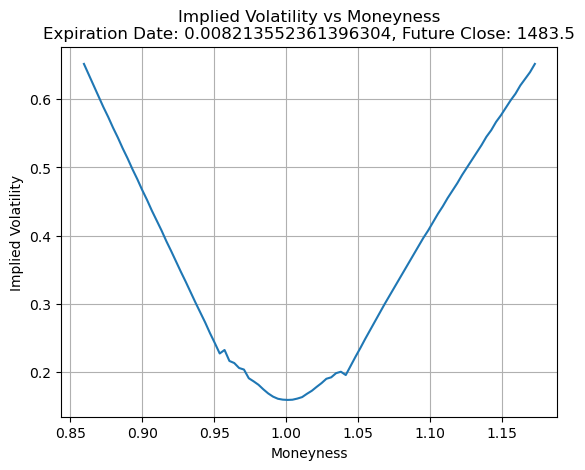

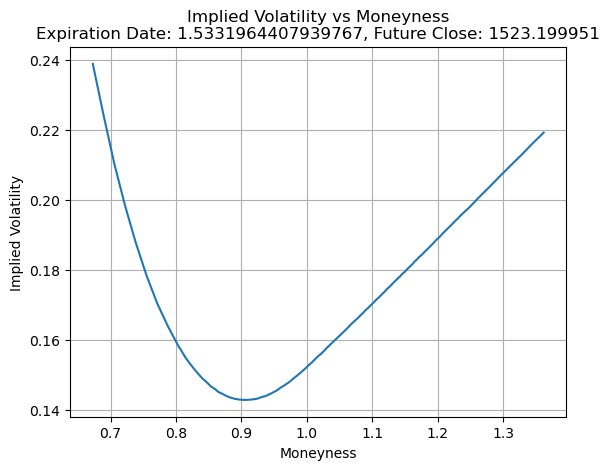

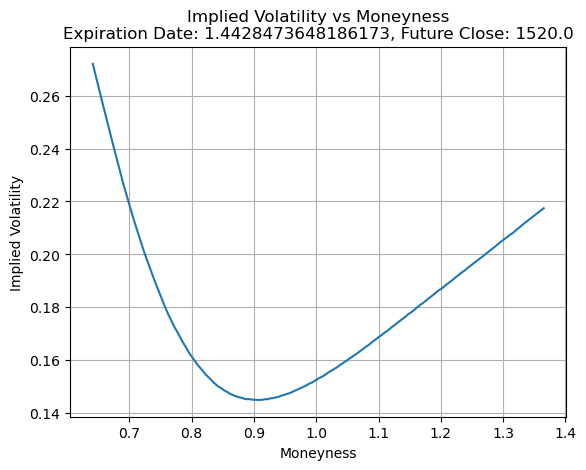

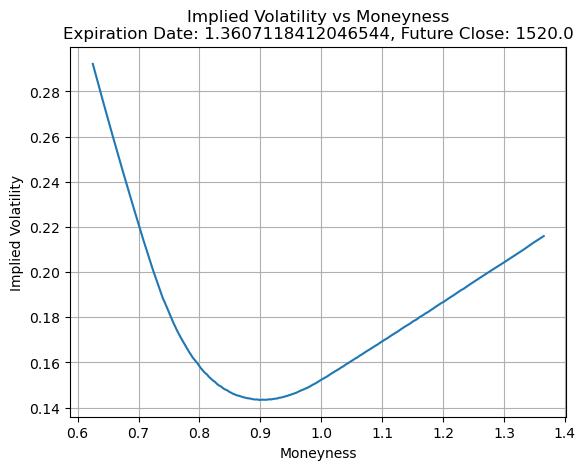

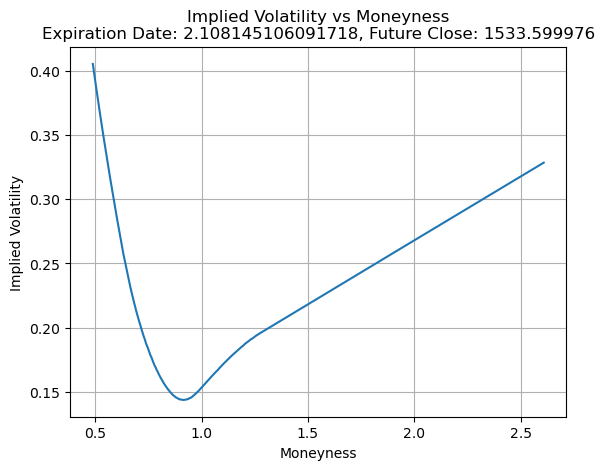

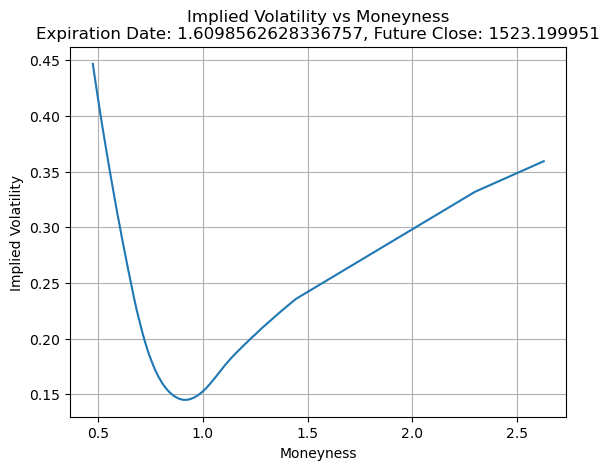

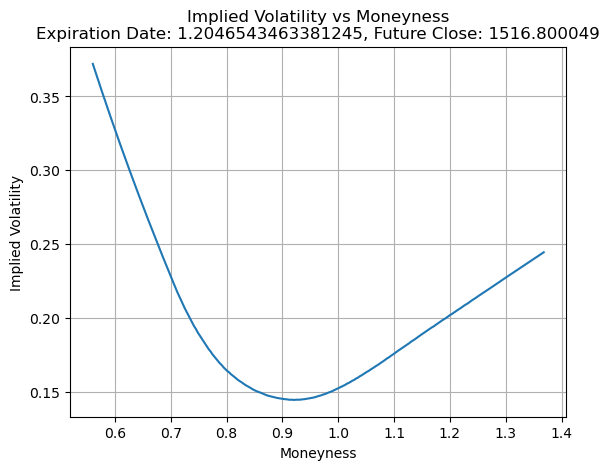

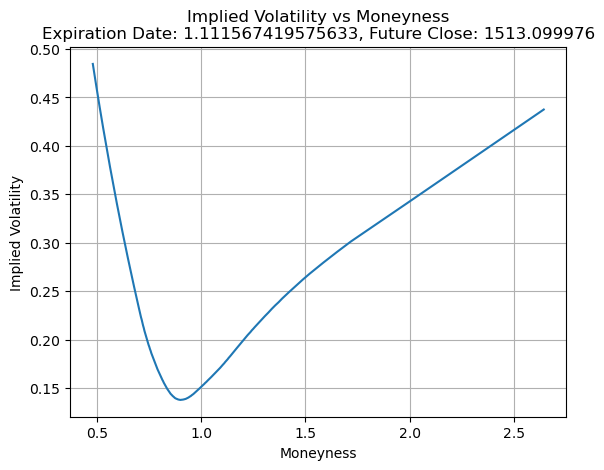

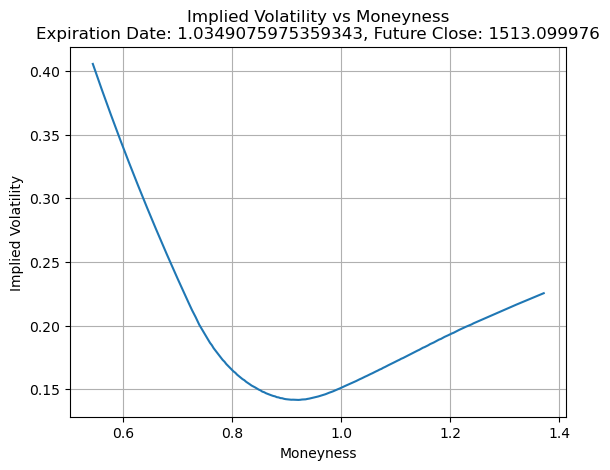

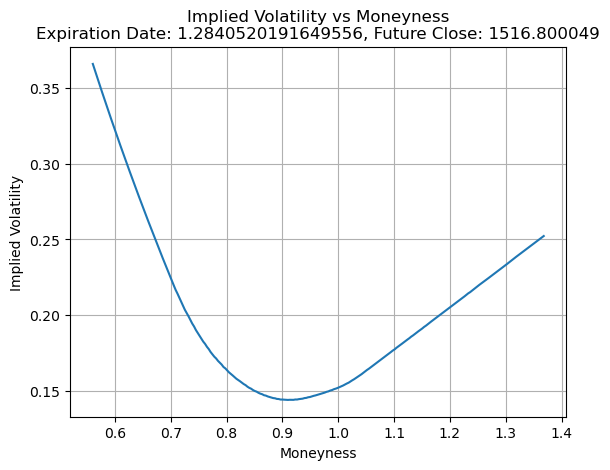

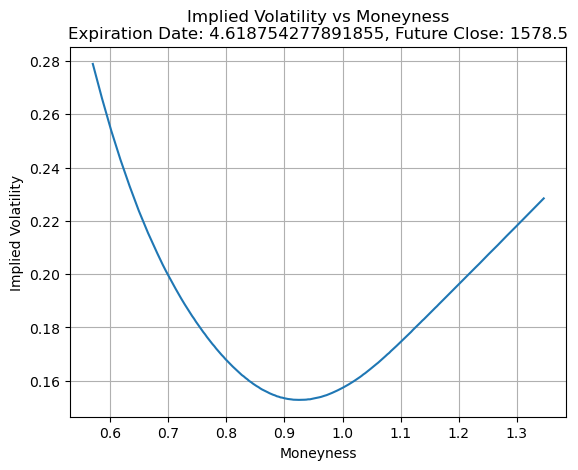

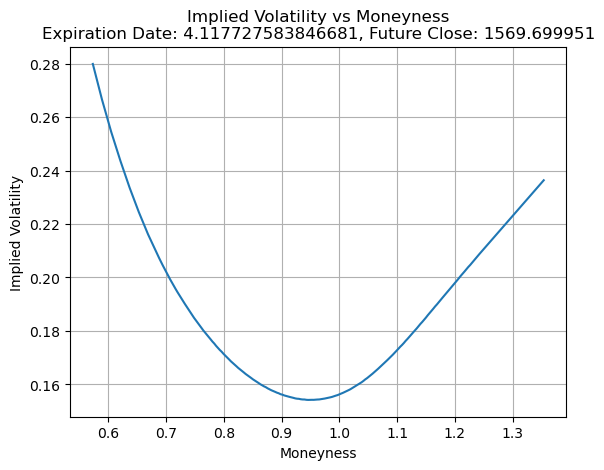

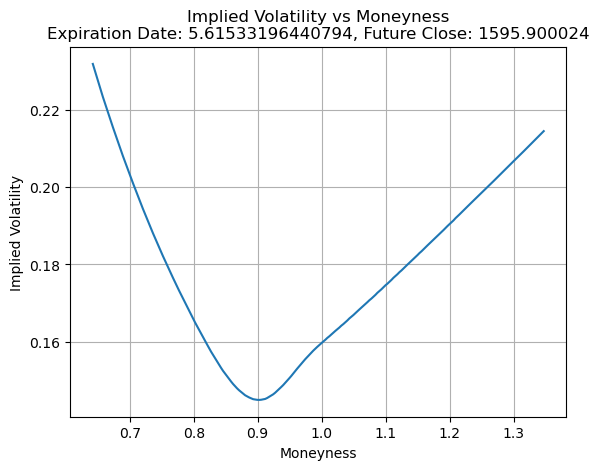

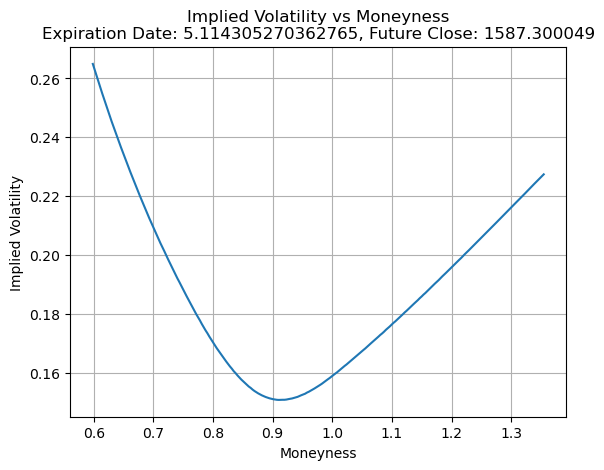

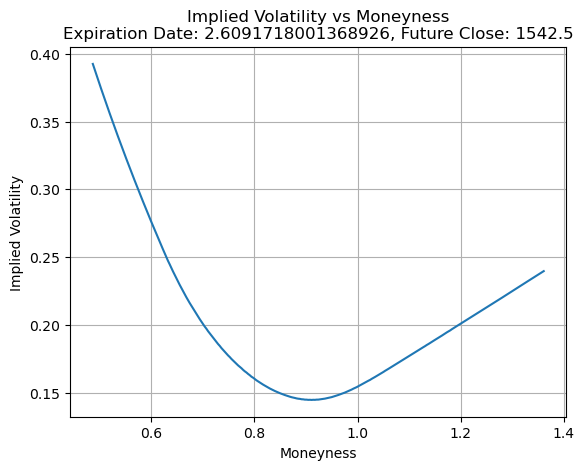

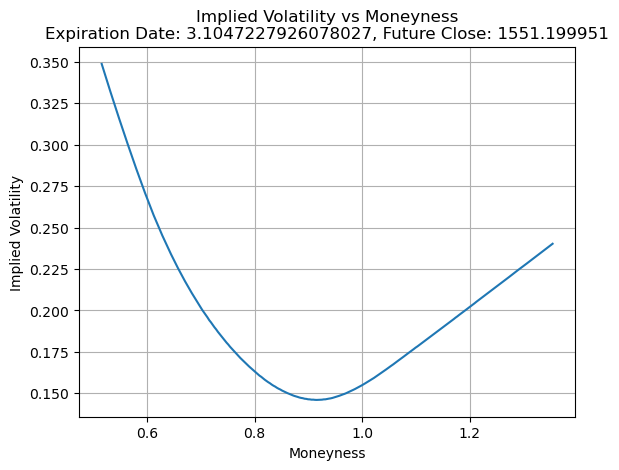

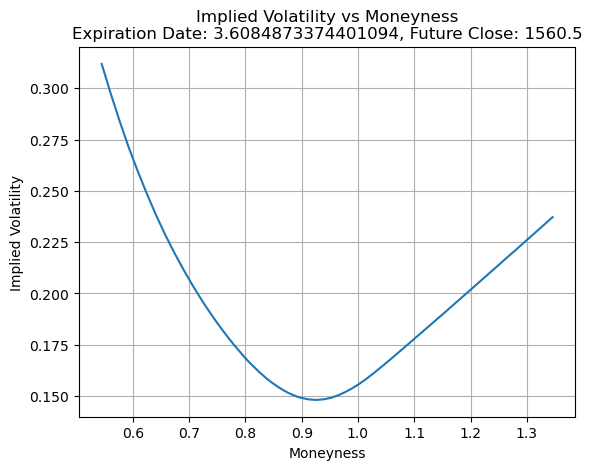

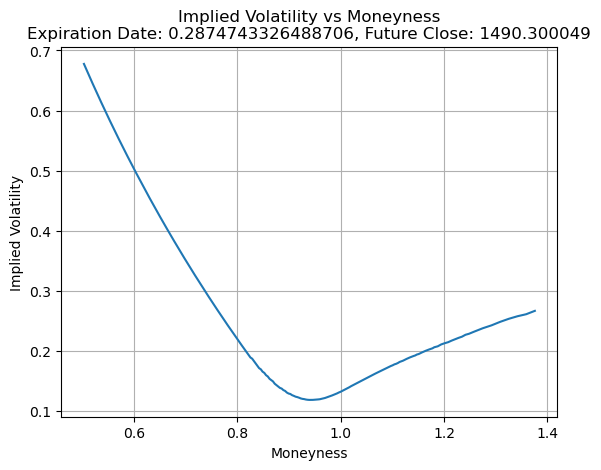

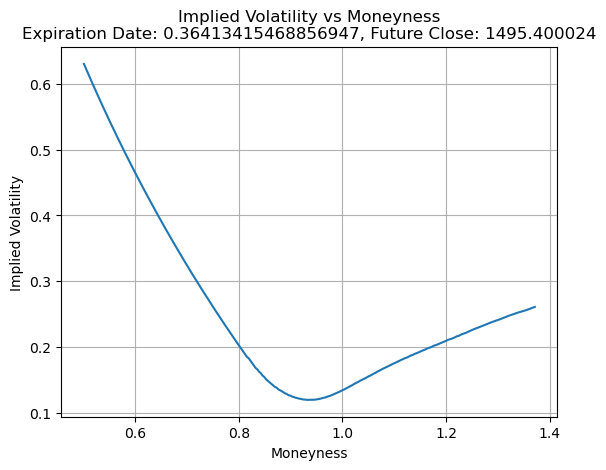

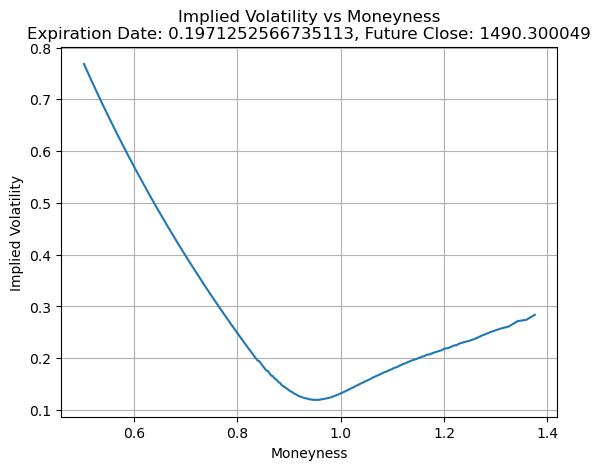

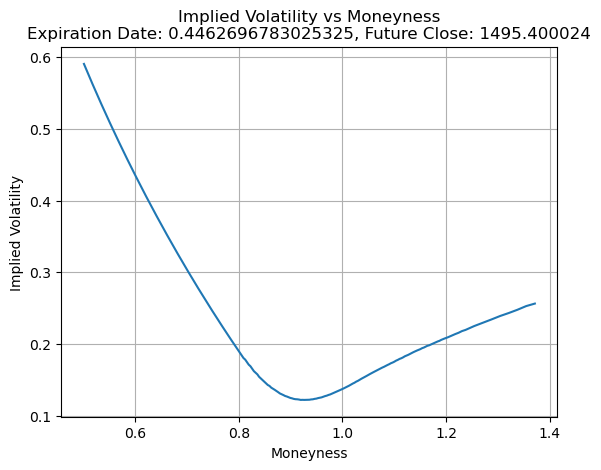

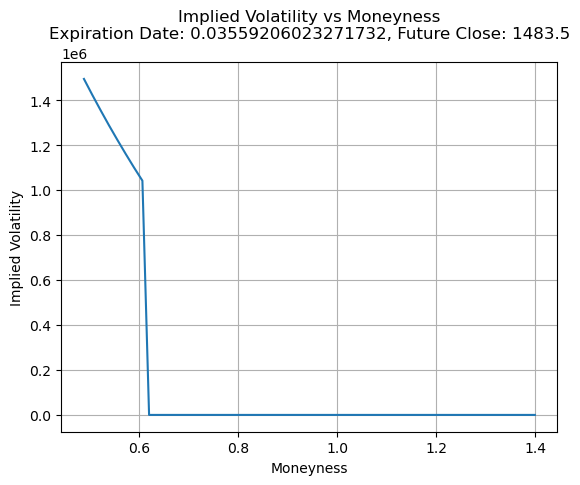

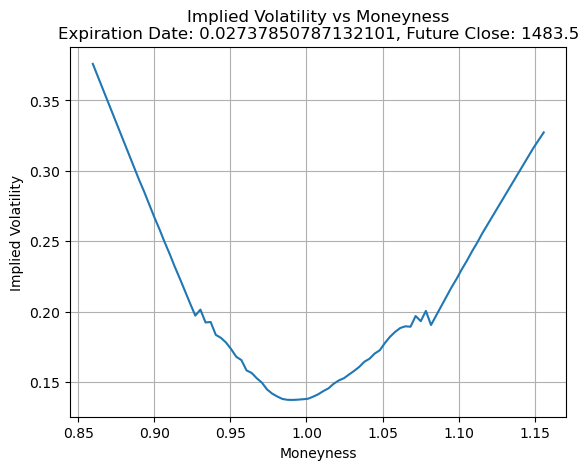

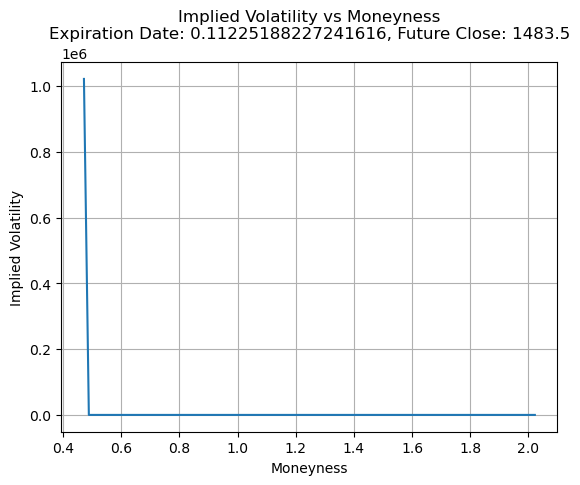

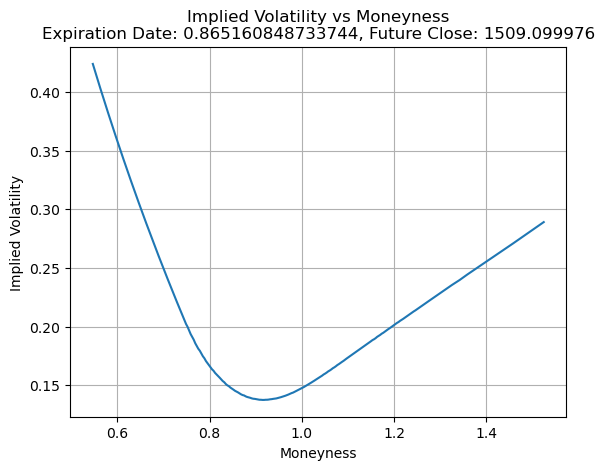

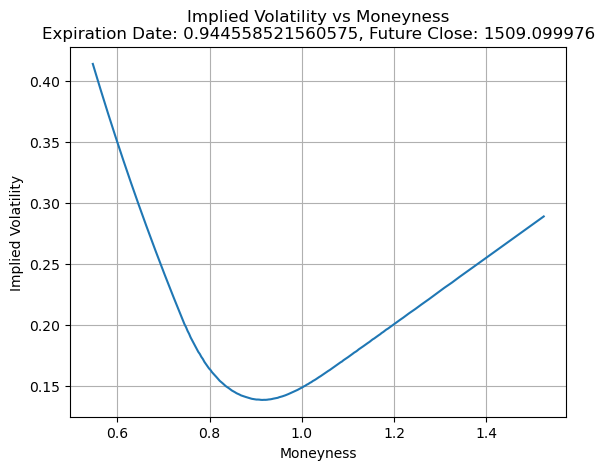

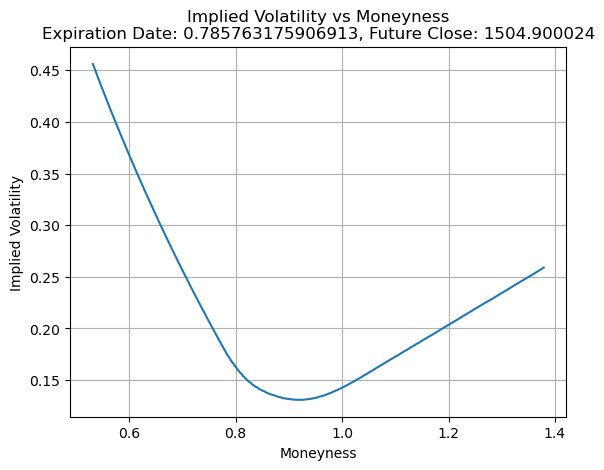

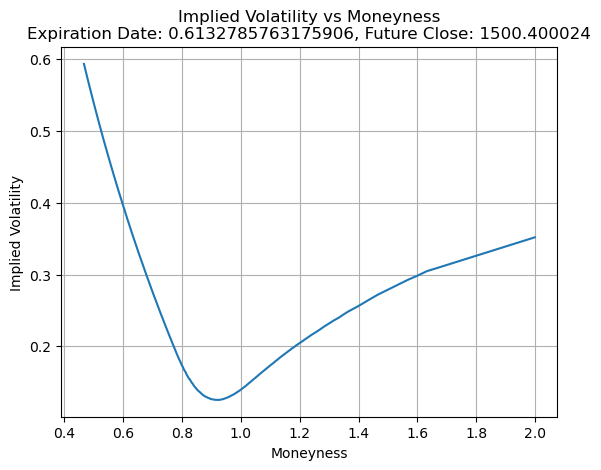

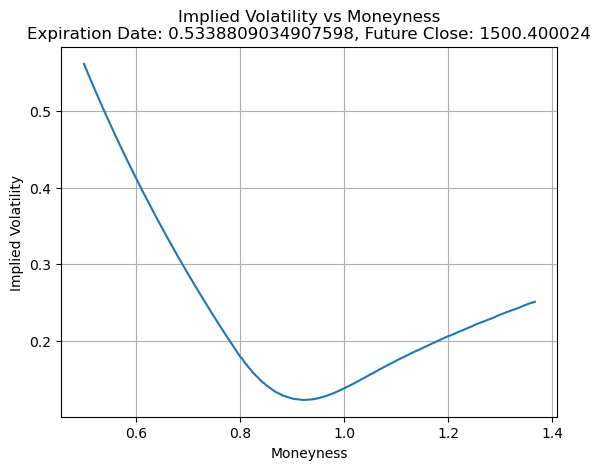

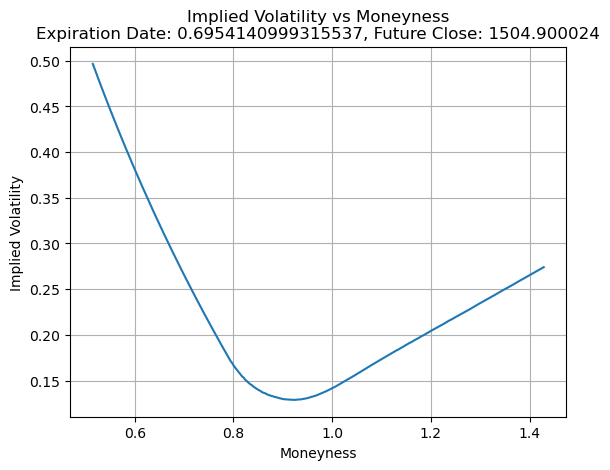

In [4]:
unique_combinations = Gold_call[['TTM', 'futures_close']].drop_duplicates()
kurtosis = []
skewness = []
labels = []
plotdata = []
for index, row in unique_combinations.iterrows():
    specific_expiration_date = row['TTM']
    specific_future_close = row['futures_close']
    
    # Filter data for the specific combination
    specific_conditions = (Gold_call['TTM'] == specific_expiration_date) & (Gold_call['futures_close'] == specific_future_close)
    filtered_data = Gold_call[specific_conditions]
    
    sorted_data = filtered_data.sort_values(by='Moneyness')
    plotdata.append(sorted_data)
    kurtosis_value = filtered_data['iv'].kurtosis()
    if kurtosis_value <20:
        kurtosis.append(kurtosis_value)
        labels.append(f'{specific_expiration_date} - {specific_future_close}')
        skewness.append(filtered_data['iv'].skew())
    plt.figure()
    plt.plot(sorted_data['Moneyness'], sorted_data['iv'])
    plt.title(f'Implied Volatility vs Moneyness\nExpiration Date: {specific_expiration_date}, Future Close: {specific_future_close}')
    plt.xlabel('Moneyness')
    plt.ylabel('Implied Volatility')
    plt.grid(True)

In [5]:
combined_df = pd.concat(plotdata, ignore_index=True)
combined_df

date underlying exchange root_symbol futures_symbol  \
0    2019-10-15         GC    COMEX         OG3      GC/19Z.CX   
1    2019-10-15         GC    COMEX         OG3      GC/19Z.CX   
2    2019-10-15         GC    COMEX         OG3      GC/19Z.CX   
3    2019-10-15         GC    COMEX         OG3      GC/19Z.CX   
4    2019-10-15         GC    COMEX         OG3      GC/19Z.CX   
...         ...        ...      ...         ...            ...   
5215 2019-10-15         GC    COMEX          GC      GC/20Q.CX   
5216 2019-10-15         GC    COMEX          GC      GC/20Q.CX   
5217 2019-10-15         GC    COMEX          GC      GC/20Q.CX   
5218 2019-10-15         GC    COMEX          GC      GC/20Q.CX   
5219 2019-10-15         GC    COMEX          GC      GC/20Q.CX   

     futures_expiration_date  futures_close options_expiration_date  strike  \
0                 2019-12-27    1483.500000              2019-10-18  1275.0   
1                 2019-12-27    1483.500000              2019-10-18  1280.0   
2                 2019-12-27    1483.500000              2019-10-18  1285.0   
3                 2019-12-27    1483.500000              2019-10-18  1290.0   
4                 2019-12-27    1483.500000              2019-10-18  1295.0   
...                      ...            ...                     ...     ...   
5215              2020-08-27    1504.900024              2020-06-25  2000.0   
5216              2020-08-27    1504.900024              2020-06-25  2025.0   
5217              2020-08-27    1504.900024              2020-06-25  2050.0   
5218              2020-08-27    1504.900024              2020-06-25  2075.0   
5219              2020-08-27    1504.900024              2020-06-25  2150.0   

     call_put  ...        iv  iv_interpolated  volume  open_interest  \
0           C  ...  0.651953         0.651953       0              0   
1           C  ...  0.636147         0.636147       0              0   
2           C  ...  0.620342         0.620342       0              0   
3           C  ...  0.604536         0.604536       0              0   
4           C  ...  0.588730         0.588730       0              0   
...       ...  ...       ...              ...     ...            ...   
5215        C  ...  0.243532         0.243532       0              0   
5216        C  ...  0.248757         0.248757       0              0   
5217        C  ...  0.253696         0.253696       0              0   
5218        C  ...  0.258873         0.258873       0              0   
5219        C  ...  0.274099         0.274099       0           4000   

         delta          vega     gamma     theta       TTM  Moneyness  
0     0.995230  1.864800e-08  0.000158 -0.191653  0.008214   0.859454  
1     0.995161  1.888500e-08  0.000164 -0.189547  0.008214   0.862824  
2     0.995092  1.912200e-08  0.000170 -0.187292  0.008214   0.866195  
3     0.995024  1.936000e-08  0.000177 -0.184918  0.008214   0.869565  
4     0.994955  1.959700e-08  0.000184 -0.182411  0.008214   0.872936  
...        ...           ...       ...       ...       ...        ...  
5215  0.097068  2.126063e+00  0.000569 -0.101235  0.695414   1.328992  
5216  0.092300  2.048575e+00  0.000537 -0.099654  0.695414   1.345604  
5217  0.087742  1.972924e+00  0.000507 -0.097894  0.695414   1.362217  
5218  0.083862  1.907250e+00  0.000481 -0.096569  0.695414   1.378829  
5219  0.074109  1.736715e+00  0.000413 -0.093138  0.695414   1.428666  

[5220 rows x 24 columns]

In [6]:
# Load the dataset

#Filter so only call options are included, REMEMBER TO TRAIN ON A PUT DATAFRAME AS WELL

# Drop non-numeric columns if there are any
data = Gold_call.select_dtypes(include=[np.number])
data = data.drop(['delta', 'vega', 'gamma', 'theta'], axis=1)
mask = data['iv'] > 1000
data = data[~mask]
#data = data.reset_index(drop=True,inplace=True)
data

futures_close  strike  bid  ask  settlement        iv  iv_interpolated  \
0        1483.500000  1275.0  0.0  0.0  208.600006  0.651953         0.651953   
7306     1523.199951  1240.0  0.0  0.0  293.299988  0.155148         0.155148   
7304     1523.199951  1230.0  0.0  0.0  302.200012  0.157257         0.157257   
7302     1523.199951  1225.0  0.0  0.0  306.600006  0.158140         0.158140   
7300     1523.199951  1220.0  0.0  0.0  311.100006  0.159270         0.159270   
...              ...     ...  ...  ...         ...       ...              ...   
3810     1504.900024  1095.0  0.0  0.0  409.899994  0.236580         0.236580   
3808     1504.900024  1090.0  0.0  0.0  414.899994  0.239999         0.239999   
3806     1504.900024  1085.0  0.0  0.0  419.899994  0.243437         0.243437   
3842     1504.900024  1175.0  0.0  0.0  329.899994  0.183995         0.183995   
10776    1595.900024  2150.0  0.0  0.0  143.000000  0.214597         0.214597   

       volume  open_interest       TTM  Moneyness  
0           0              0  0.008214   0.859454  
7306        0              0  1.533196   0.814076  
7304        0              0  1.533196   0.807511  
7302        0              0  1.533196   0.804228  
7300        0              0  1.533196   0.800945  
...       ...            ...       ...        ...  
3810        0              0  0.695414   0.727623  
3808        0              0  0.695414   0.724301  
3806        0              0  0.695414   0.720978  
3842        0              0  0.695414   0.780783  
10776       0              0  5.615332   1.347202  

[5211 rows x 11 columns]

In [7]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data)

# Preprocess the data
#scaler = MinMaxScaler((-1, 1))
#data_scaled = scaler.fit_transform(data)

In [8]:
# Define the generator and discriminator models
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(100,)),
        layers.Dense(data_scaled.shape[1], activation='tanh')
    ])
    return model

def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(data_scaled.shape[1],)),
        layers.Dense(1, activation='sigmoid')
    ])
    return model




### first GAN

# Define batch size and noise dimension
BATCH_SIZE = 128
NOISE_DIM = 75
 
# Define the generator and discriminator models
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(75,)),
        layers.Dense(data_scaled.shape[1], activation='tanh')
    ])
    return model

def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(data_scaled.shape[1],)),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Instantiate the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

# Define the training loop

@tf.function
def train_step(real_data):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)
        
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)
        
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = (cross_entropy(tf.ones_like(real_output), real_output) +
                     cross_entropy(tf.zeros_like(fake_output), fake_output))
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for data_batch in dataset:
            train_step(data_batch)
        print(f'\rEpoch {epoch + 1}/{epochs} completed', end = '', flush=True)  # Print the current epoch count
# Prepare the dataset
BUFFER_SIZE = 5389 
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(data_scaled).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Train the GAN
train(train_dataset, epochs=1000)

In [9]:
### first GAN

# Define batch size and noise dimension
BATCH_SIZE = 128
NOISE_DIM = 75
 
# Define the generator and discriminator models
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(75,)),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(data_scaled.shape[1], activation='tanh')
    ])
    return model

def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(data_scaled.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


# Instantiate the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy()
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

# Define the training loop

@tf.function
def train_step(real_data):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)
        
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)
        
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = (cross_entropy(tf.ones_like(real_output), real_output) +
                     cross_entropy(tf.zeros_like(fake_output), fake_output))
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for data_batch in dataset:
            train_step(data_batch)
        print(f'\rEpoch {epoch + 1}/{epochs} completed', end = '', flush=True)  # Print the current epoch count
# Prepare the dataset
BUFFER_SIZE = 5389 
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(data_scaled).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Train the GAN
train(train_dataset, epochs=10000)


Epoch 10000/10000 completed


In the context of training neural networks, particularly Generative Adversarial Networks (GANs), the terms BATCH_SIZE, NOISE_DIM, and BUFFER_SIZE have specific meanings:

BATCH_SIZE (256): This refers to the number of training examples used in one iteration of model training. In a dataset, data is usually divided into batches, and each batch is fed into the network one at a time. A batch size of 256 means that 256 data points from the dataset are used for each training step.

NOISE_DIM (100): This is specific to GANs, particularly the generator part of the GAN. It refers to the dimensionality of the random noise vector that is input into the generator network. A noise dimension of 100 means that the generator takes in a random vector of size 100 to generate data.

BUFFER_SIZE (60000): This is typically used with data loading and shuffling operations. It defines the size of the buffer used to shuffle the dataset. A larger buffer size ensures better randomization of data. In TensorFlow, for example, Dataset.shuffle(buffer_size) randomly shuffles the elements of the dataset. A buffer size of 60000 in this context would mean the dataset is shuffled using a buffer that can hold 60000 elements.

In [10]:
# Generate random noise
num_examples_to_generate=6000
random_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])

# Use the generator to create images
simulated_data = generator(random_noise, training=False)

# If necessary, rescale the data to the original scale
# This step depends on how you've preprocessed your training data
simulated_data_rescaled = scaler.inverse_transform(simulated_data)

# Convert the generated data to a format you can use (e.g., Pandas DataFrame)
simulated_data_df = pd.DataFrame(simulated_data_rescaled, columns=data.columns)

This code replaces each TTM value in the generated data with the nearest TTM value from the original dataset. This approach keeps the diversity of generated data while ensuring that TTM values align with realistic, observed values.

In [11]:
# Convert simulated TTM values to daily.
# Desired step for quantization
# DAILY
step_daily = 0.00273785078
# WEEKLY
step_weekly = 0.14285714285

# Quantize TTM values to the nearest multiple of the step
simulated_data_df['TTM'] = (np.round(simulated_data_df['TTM'] / step_weekly) * step_weekly).astype(float)


# Convert the original TTM values into a KDTree for efficient nearest neighbor search
#original_TTM_tree = cKDTree(np.array(data['TTM']).reshape(-1, 1))

# Replace generated TTM values with nearest original TTM values
#generated_TTM_values = simulated_data_df['TTM']
#nearest_indices = original_TTM_tree.query(generated_TTM_values.values.reshape(-1, 1))[1]
#simulated_data_df['TTM'] = np.array(data['TTM'])[nearest_indices]

# Convert the original future_close values into a KDTree for efficient nearest neighbor search
#original_TTM_tree = cKDTree(np.array(data['futures_close']).reshape(-1, 1))

# Replace generated future_close values with nearest original future_close values
#generated_TTM_values = simulated_data_df['futures_close']
#nearest_indices = original_TTM_tree.query(generated_TTM_values.values.reshape(-1, 1))[1]
#simulated_data_df['futures_close'] = np.array(data['futures_close'])[nearest_indices]

In [12]:
# Assuming simulated_data_df is your DataFrame and it has a column named 'strike'
accuracy = 5
simulated_data_df['strike'] = (simulated_data_df['strike'] / accuracy).round() * accuracy
simulated_data_df['Moneyness'] = simulated_data_df['strike']/simulated_data_df['futures_close']

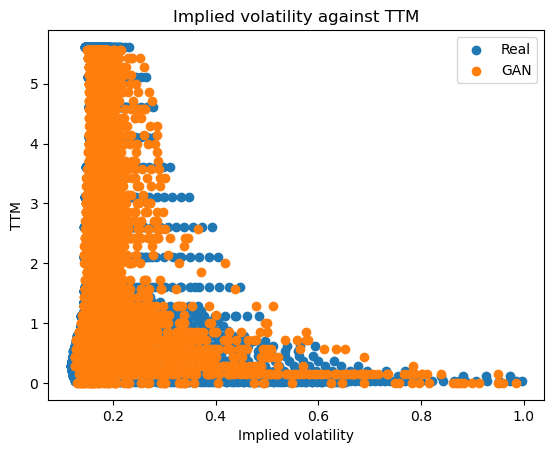

In [13]:
plt.scatter(data['iv'], data['TTM'], label = "Real")
plt.scatter(simulated_data_df['iv'], simulated_data_df['TTM'], label = "GAN")
plt.title("Implied volatility against TTM")
plt.xlabel("Implied volatility")
plt.ylabel("TTM")
plt.legend()

In [14]:
data.describe()

futures_close       strike          bid          ask    settlement  \
count    5211.000000  5211.000000  5211.000000  5211.000000  5.211000e+03   
mean     1520.018618  1457.359432    11.892957    12.010651  1.965683e+02   
std        30.487909   301.393442    53.712692    53.870262  1.700266e+02   
min      1483.500000   700.000000     0.000000     0.000000  1.000000e-07   
25%      1495.400024  1235.000000     0.000000     0.000000  5.385000e+01   
50%      1513.099976  1460.000000     0.000000     0.000000  1.531000e+02   
75%      1533.599976  1675.000000     0.000000     0.000000  3.034000e+02   
max      1595.900024  4000.000000   746.299988   747.000000  8.004000e+02   

                iv  iv_interpolated       volume  open_interest          TTM  \
count  5211.000000      5211.000000  5211.000000    5211.000000  5211.000000   
mean      0.203285         0.203285     7.148532     243.924966     1.575003   
std       0.096550         0.096550    90.233165    1357.393965     1.522932   
min       0.117828         0.117828     0.000000       0.000000     0.008214   
25%       0.152365         0.152365     0.000000       0.000000     0.446270   
50%       0.174411         0.174411     0.000000       0.000000     1.034908   
75%       0.208882         0.208882     0.000000       0.000000     2.108145   
max       0.996030         0.996030  3575.000000   30814.000000     5.615332   

         Moneyness  
count  5211.000000  
mean      0.958721  
std       0.197349  
min       0.466542  
25%       0.812383  
50%       0.959538  
75%       1.102123  
max       2.643579

In [15]:
simulated_data_df.describe()

futures_close       strike          bid          ask   settlement  \
count    6000.000000  6000.000000  6000.000000  6000.000000  6000.000000   
mean     1527.718934  1476.940000     1.318168     1.428894   198.137429   
std        29.347531   284.538173     4.920018     4.943473   153.239675   
min      1483.500000   730.000000     0.000000     0.000000     0.053981   
25%      1506.871142  1260.000000     0.203509     0.138889    73.892700   
50%      1518.544835  1485.000000     0.396198     0.302300   163.473649   
75%      1547.318617  1695.000000     0.793509     0.694574   283.184396   
max      1595.851938  2950.000000   102.740280    78.546972   762.234454   

                iv  iv_interpolated       volume  open_interest          TTM  \
count  6000.000000      6000.000000  6000.000000    6000.000000  6000.000000   
mean      0.192843         0.195054     0.244359     144.951591     1.863119   
std       0.079336         0.081379     2.214793    1250.508822     1.505009   
min       0.125569         0.123374     0.000000       0.000000     0.000000   
25%       0.154006         0.154479     0.042830       7.544071     0.714286   
50%       0.172642         0.173674     0.143461      23.691045     1.285714   
75%       0.201431         0.205781     0.266039      58.711283     2.714286   
max       0.985545         0.989294   114.357401   30572.058023     5.571429   

         Moneyness  
count  6000.000000  
mean      0.966738  
std       0.185764  
min       0.489840  
25%       0.827109  
50%       0.962571  
75%       1.105552  
max       1.952034

In [16]:
simulated_data_df['Moneyness'].value_counts()

1.065049    2
0.712619    1
1.120804    1
0.942855    1
0.677452    1
           ..
1.136619    1
1.197768    1
0.921393    1
0.604598    1
0.835945    1
Name: Moneyness, Length: 5999, dtype: int64

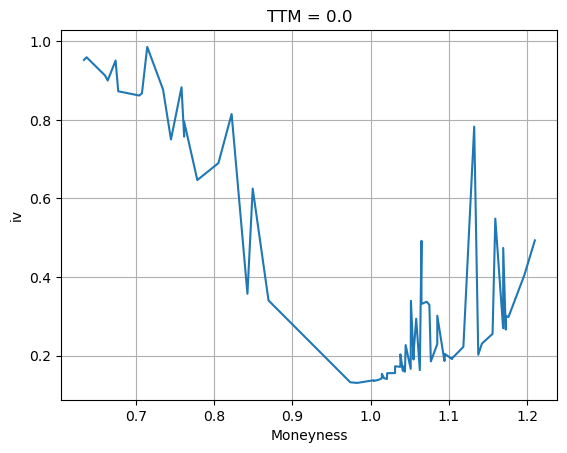

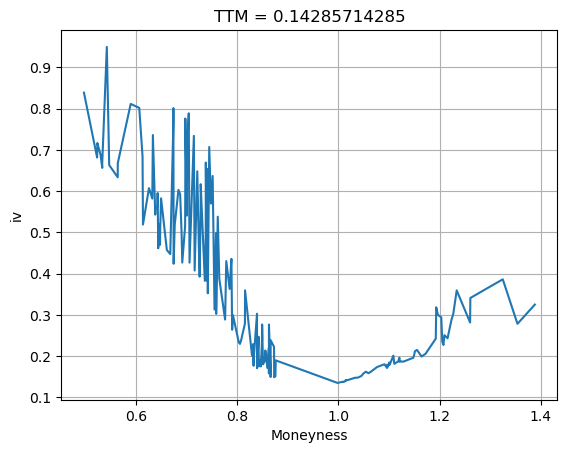

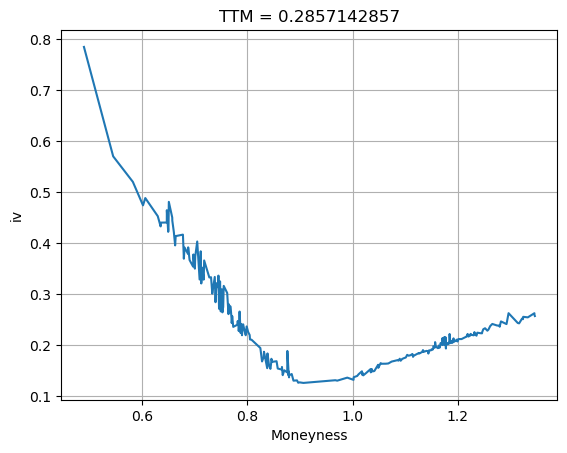

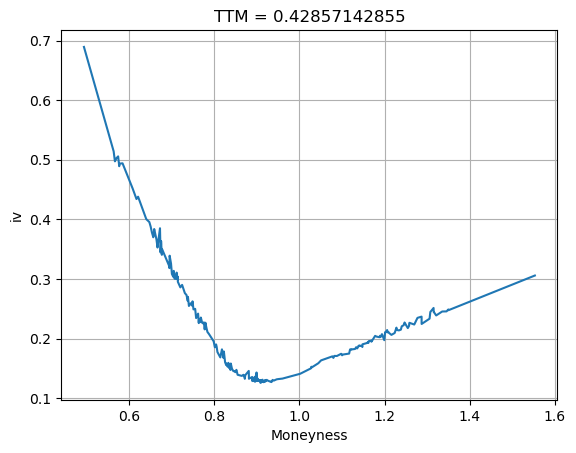

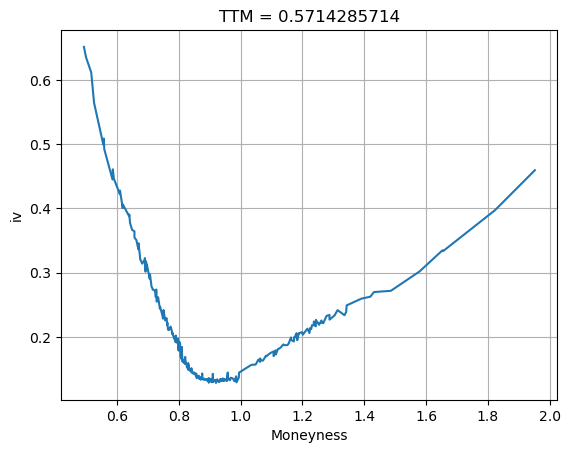

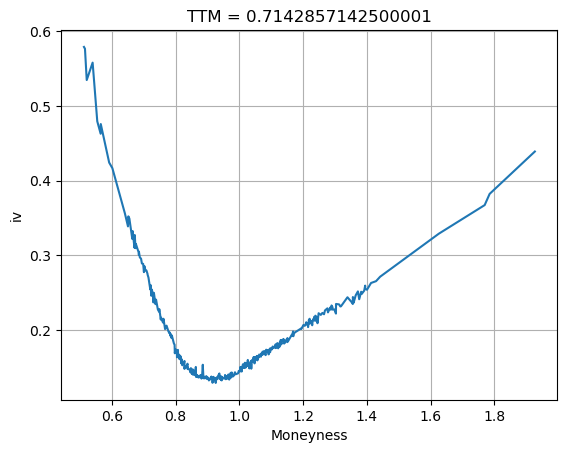

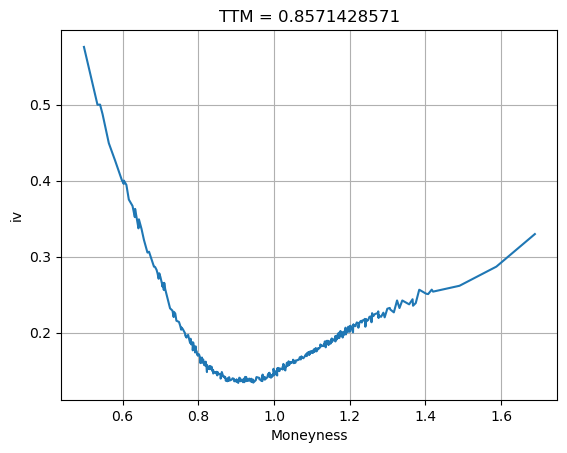

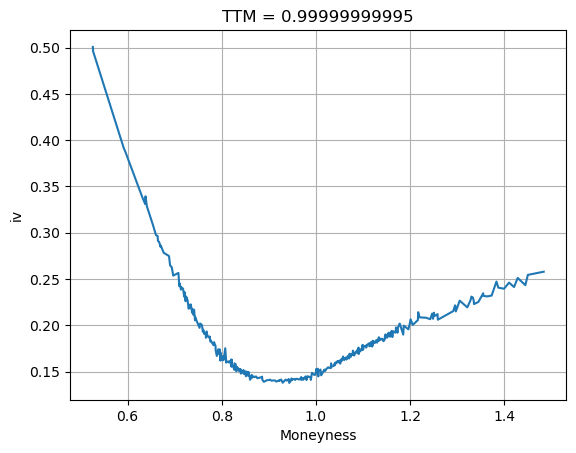

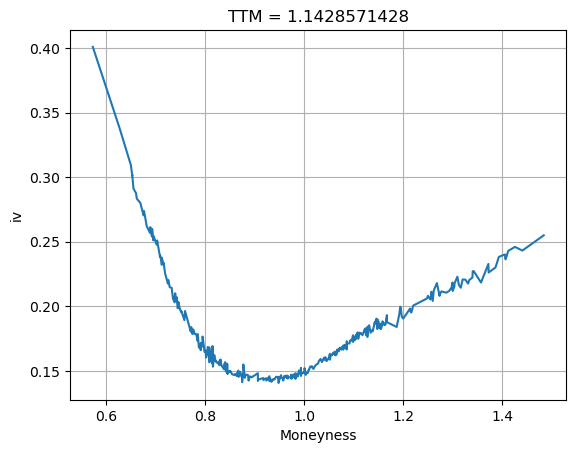

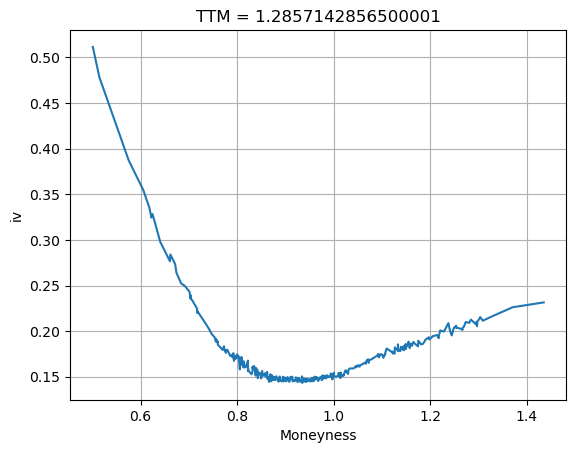

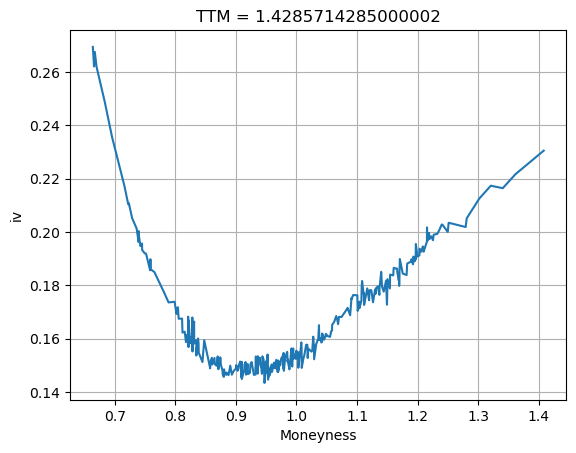

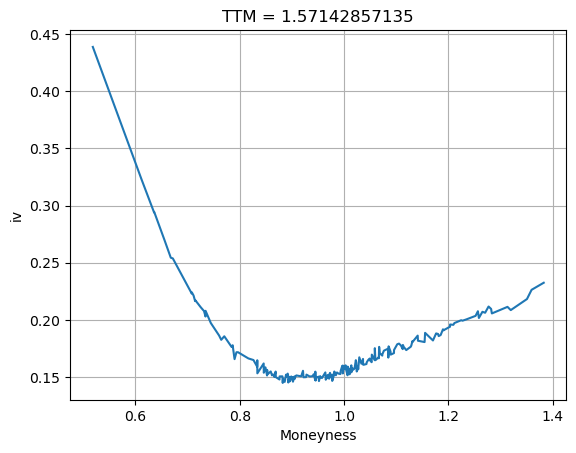

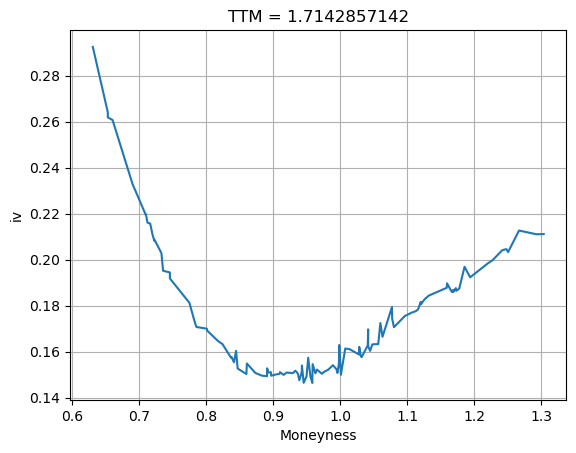

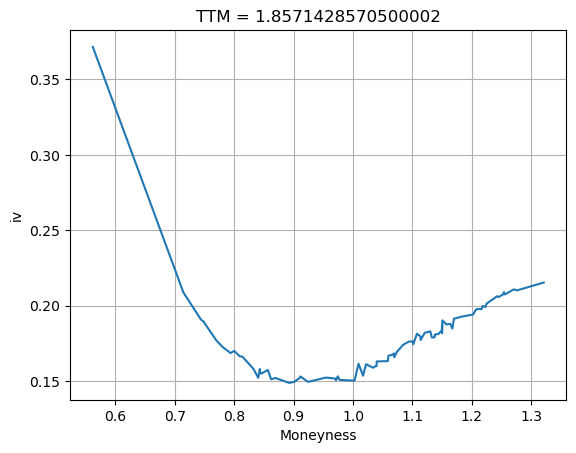

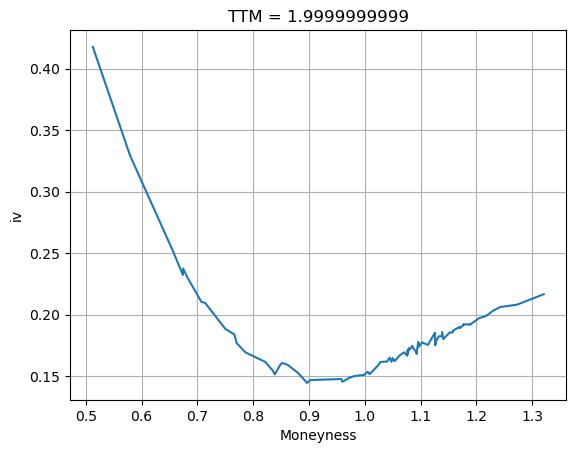

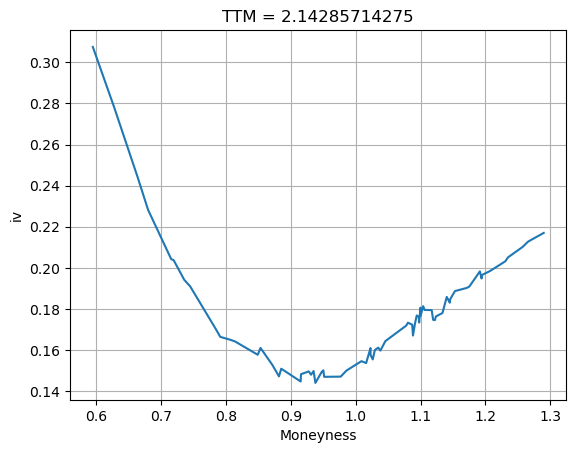

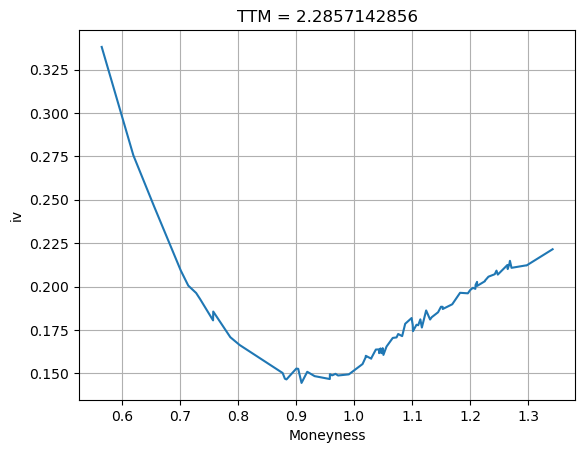

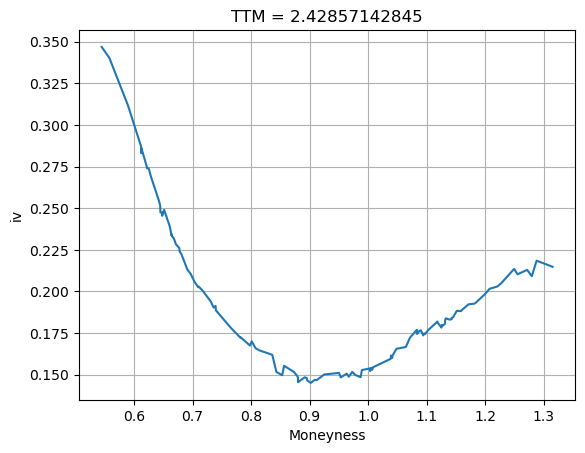

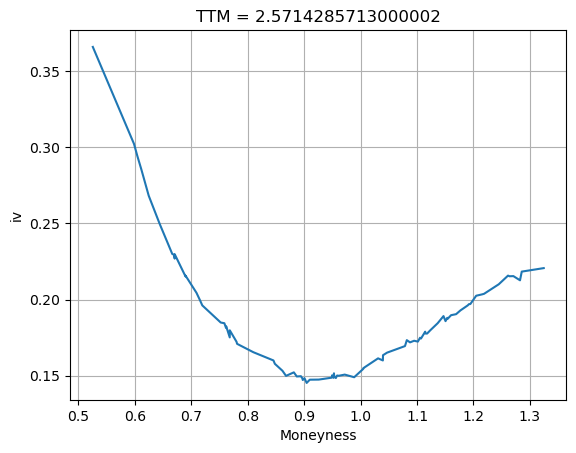

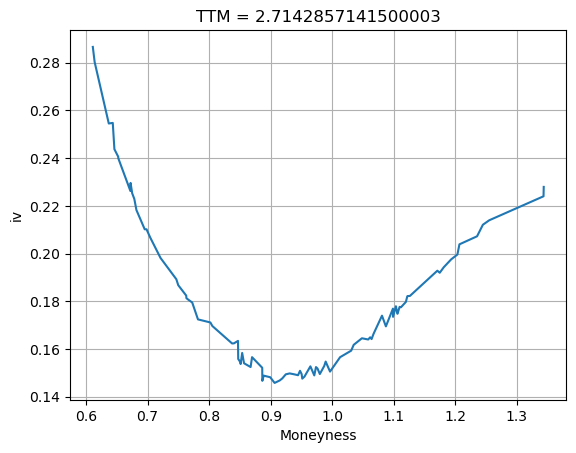

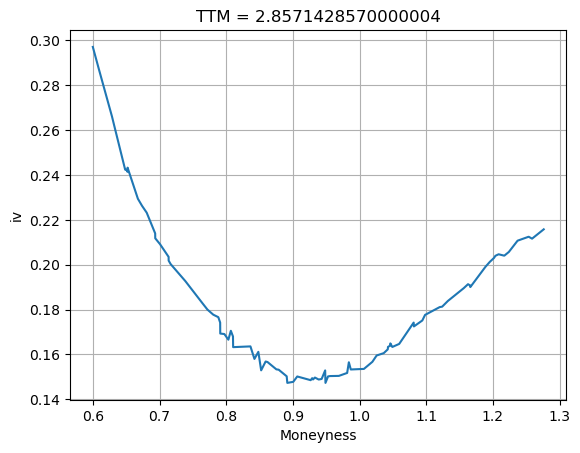

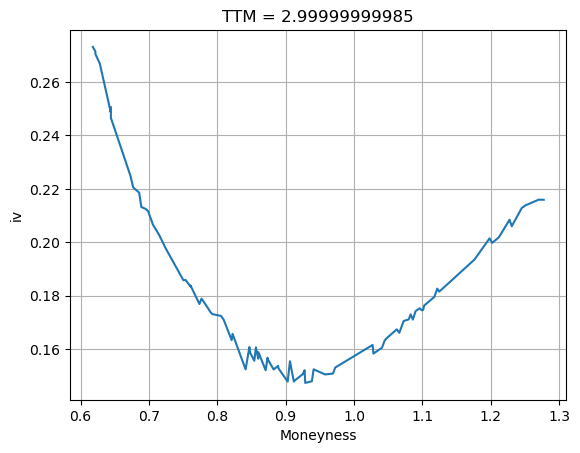

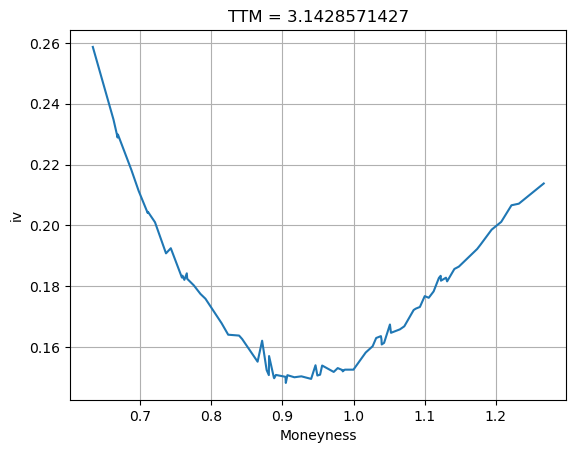

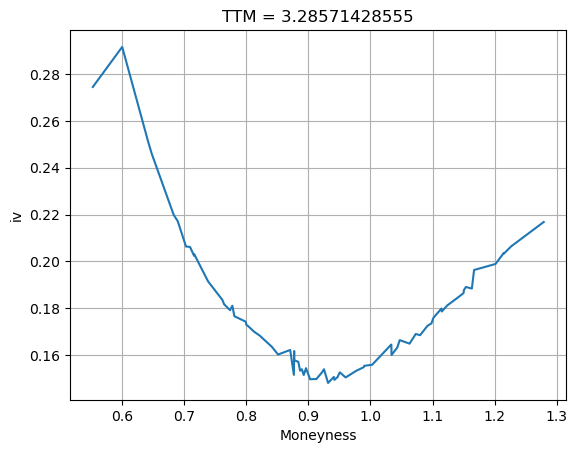

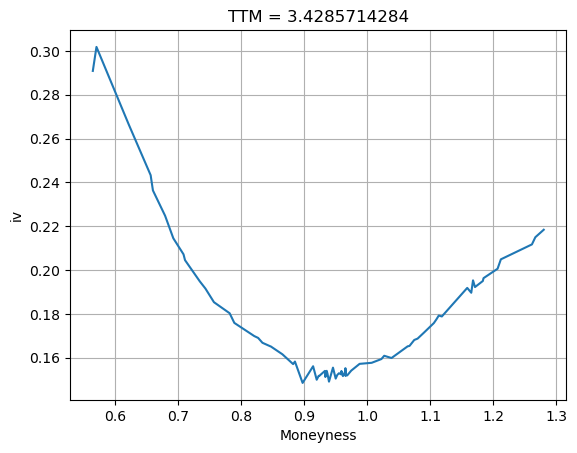

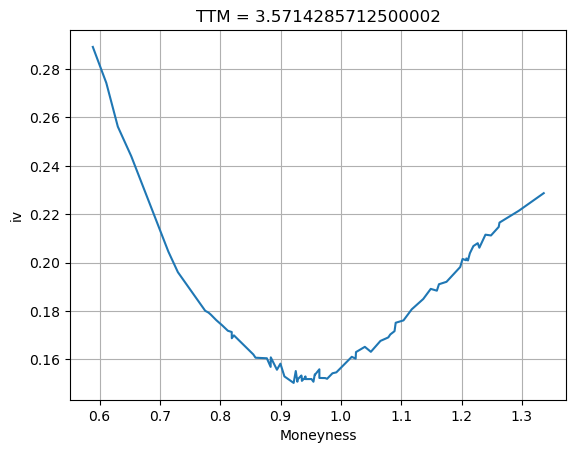

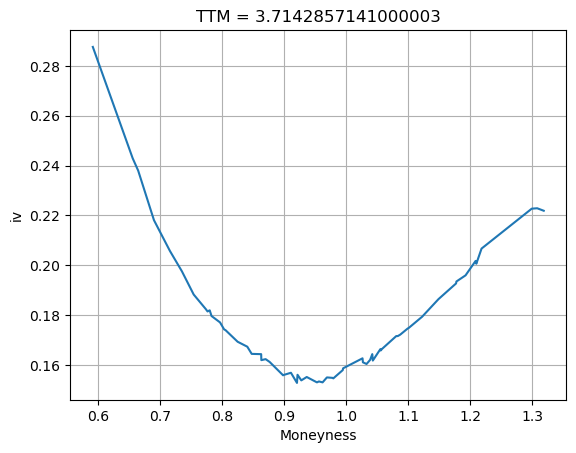

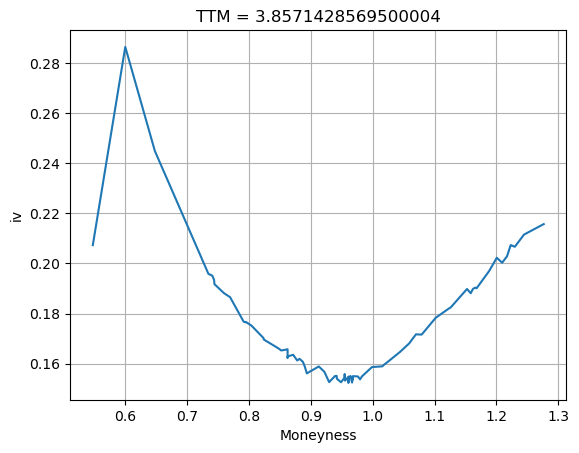

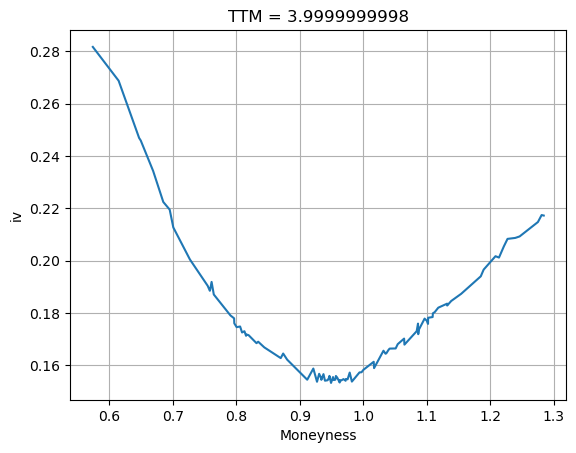

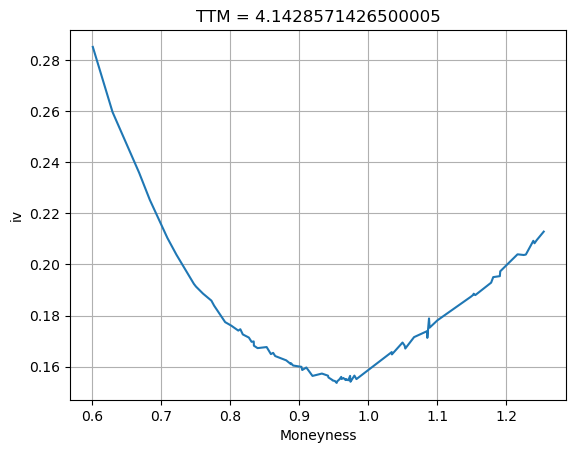

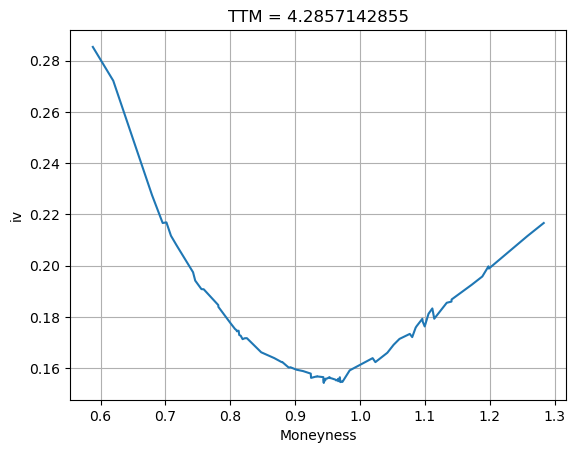

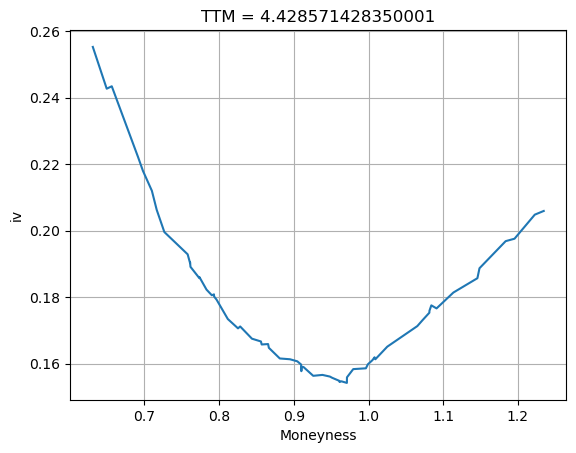

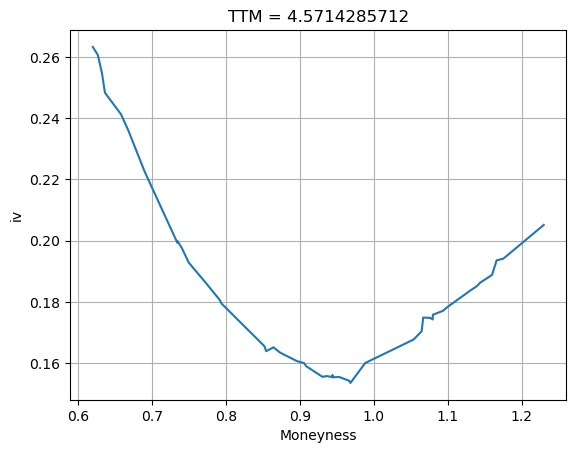

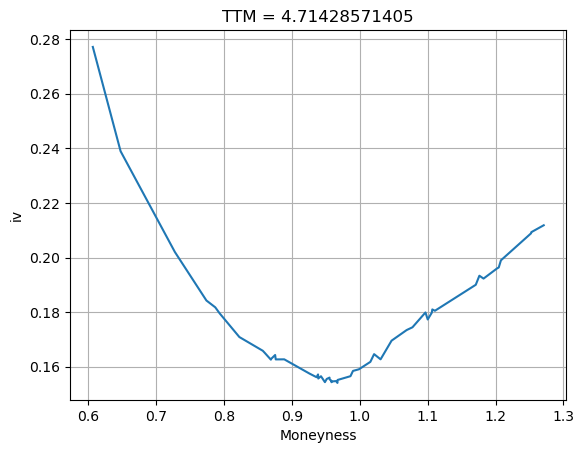

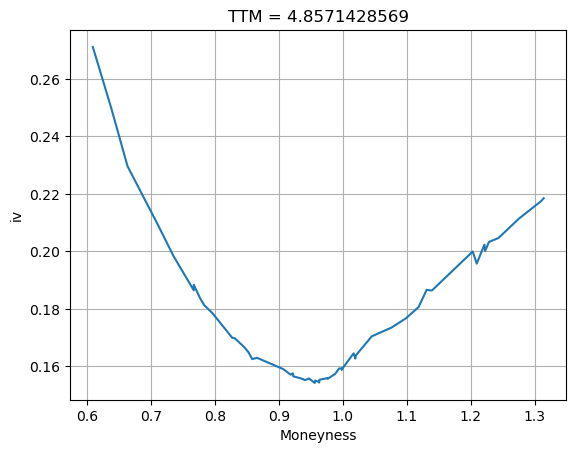

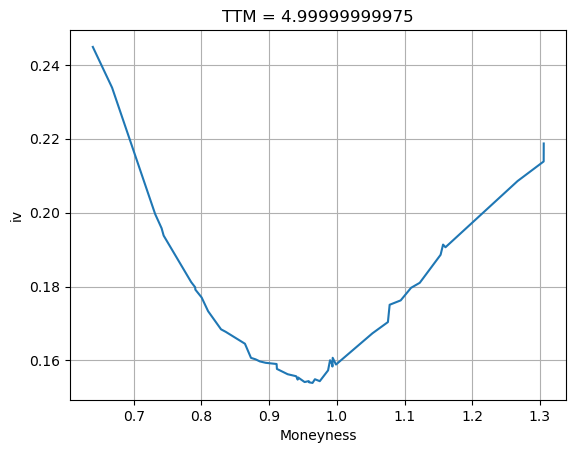

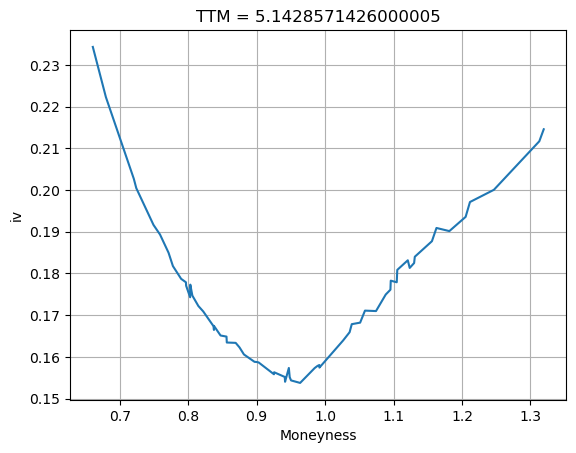

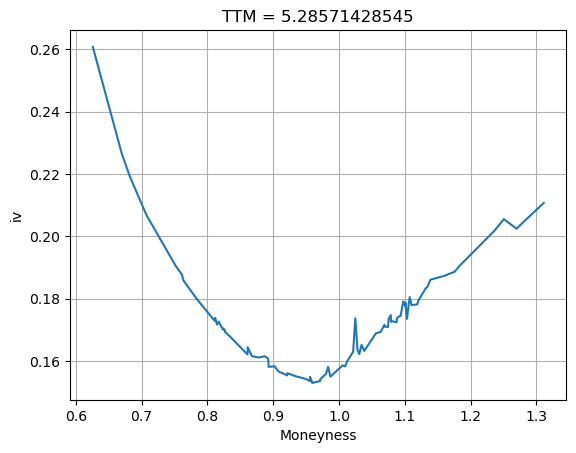

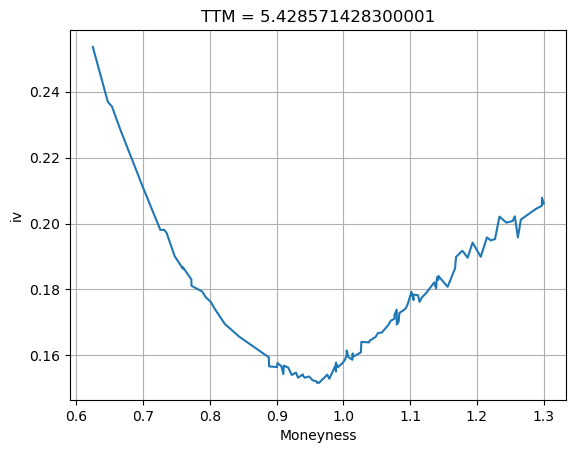

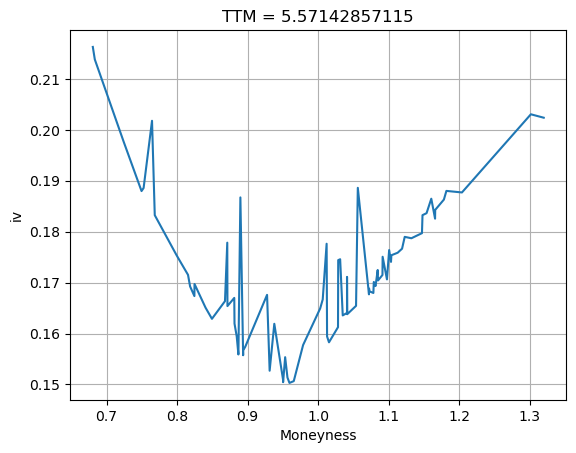

In [17]:
unique_ttms = sorted(simulated_data_df['TTM'].unique())

# Plot 'IV' against 'Moneyness' for each 'TTM'
for ttm in unique_ttms:
    subset = simulated_data_df[simulated_data_df['TTM'] == ttm]
    subset_sorted = subset.sort_values(by='Moneyness')  # Ensure sorting is done within the loop, for each subset
    plt.figure()
    plt.plot(subset_sorted['Moneyness'], subset_sorted['iv'])  # Add markers for clarity
    plt.title(f'TTM = {ttm}')
    plt.xlabel('Moneyness')
    plt.ylabel('iv')
    plt.grid(True)  # Optionally add a grid
    save_path = os.path.join(r"C:\Users\jesper\Documents\FinTech\Research Project\plots", f'TTM_{ttm}.png')
    plt.savefig(save_path)
    plt.show()  # Show plot for each TTM value

# Remove plt.tight_layout() as it is not needed when showing plots one by one

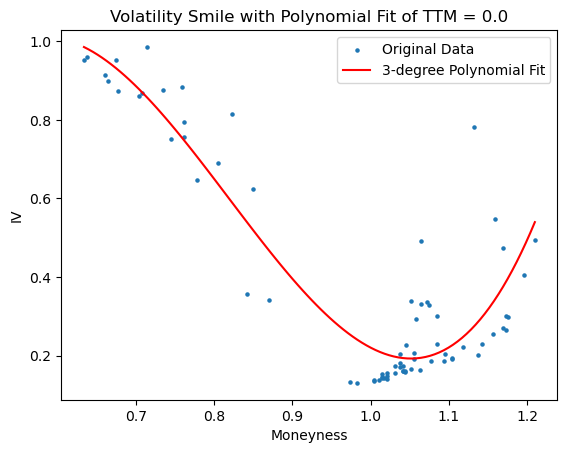

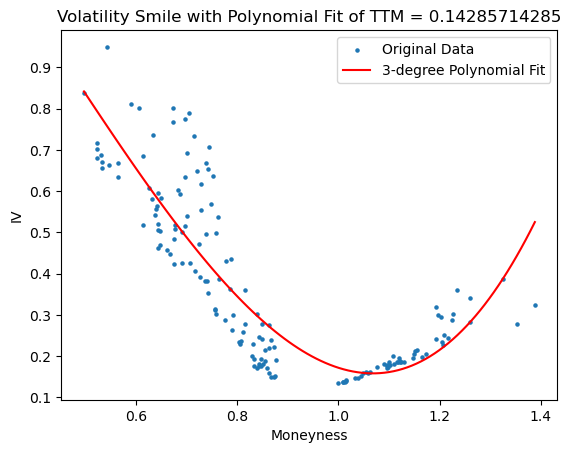

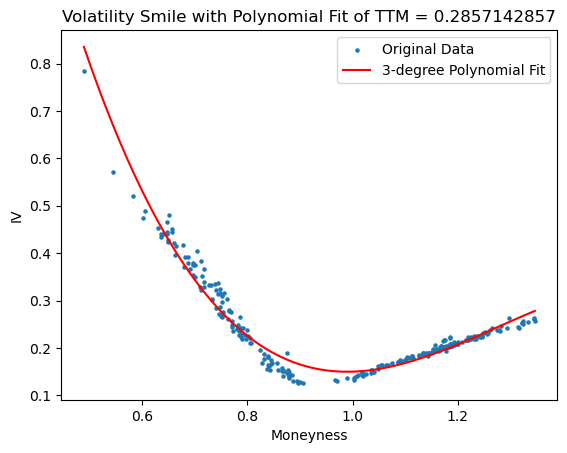

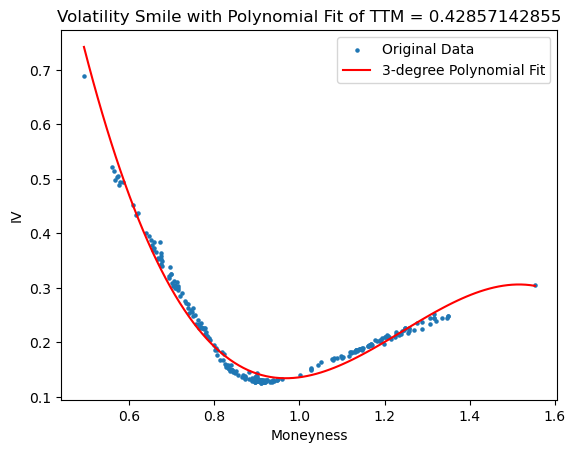

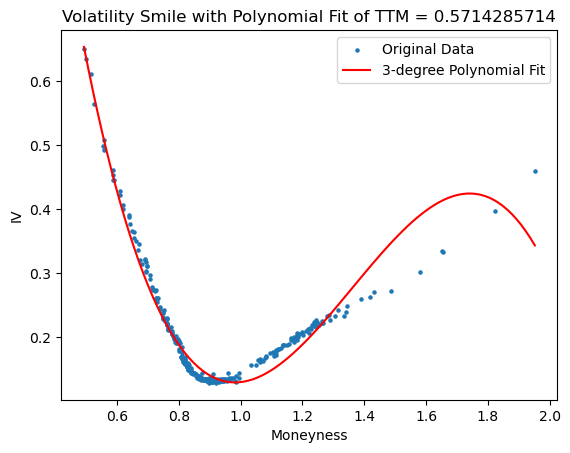

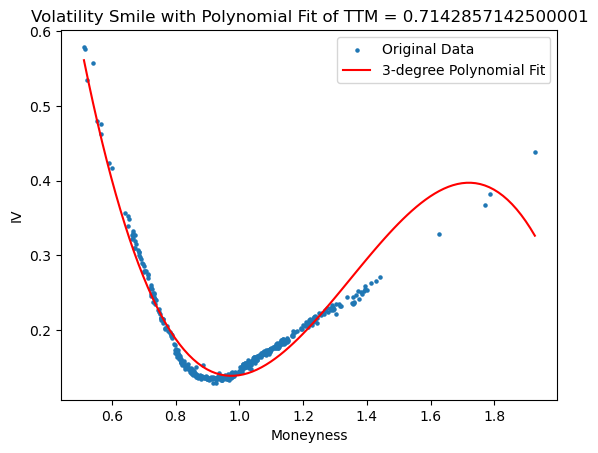

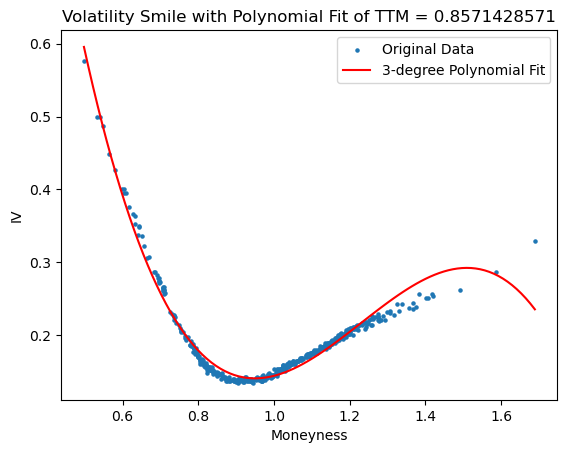

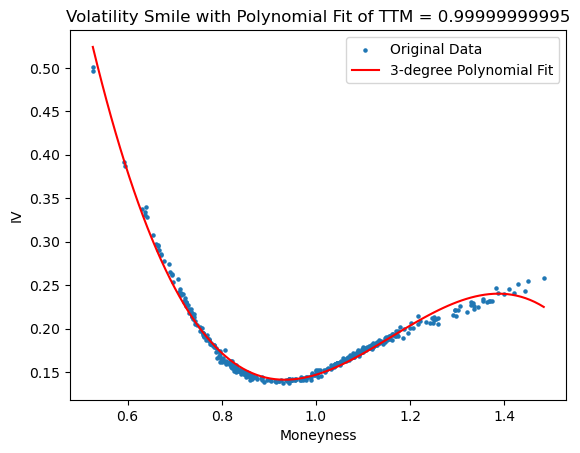

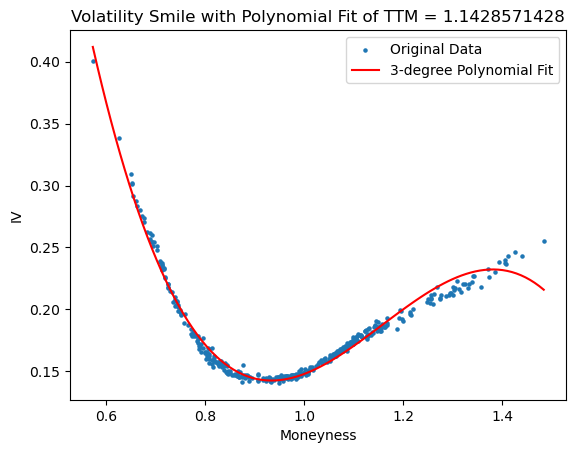

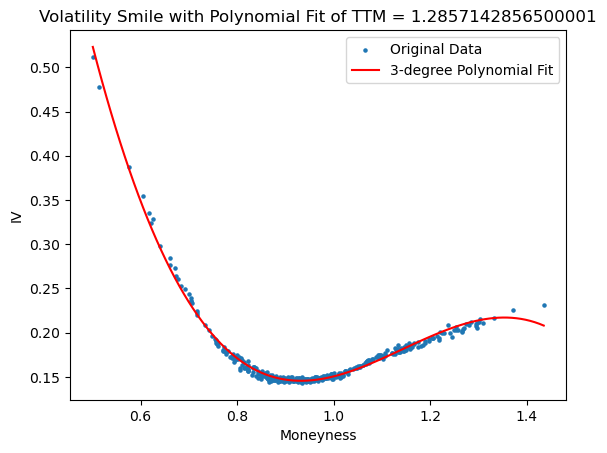

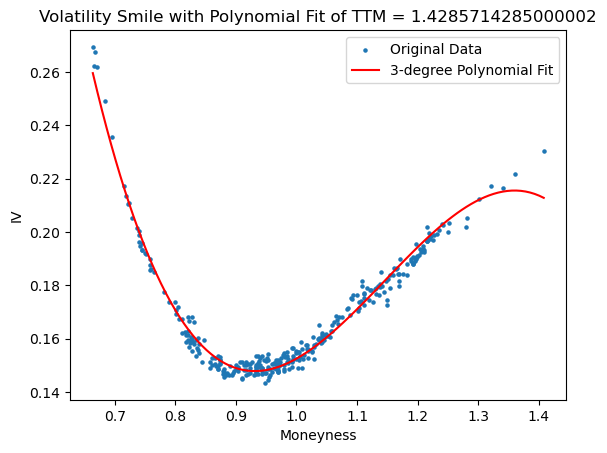

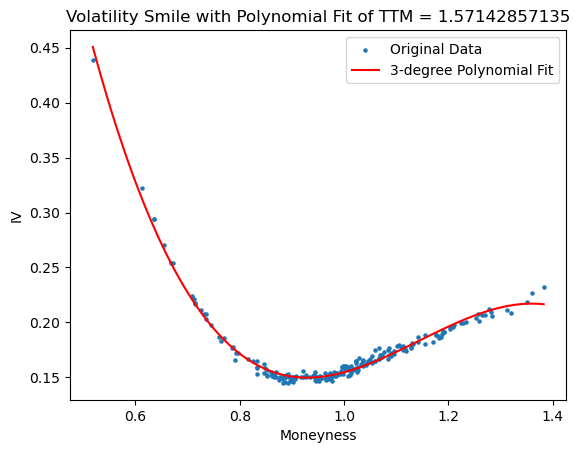

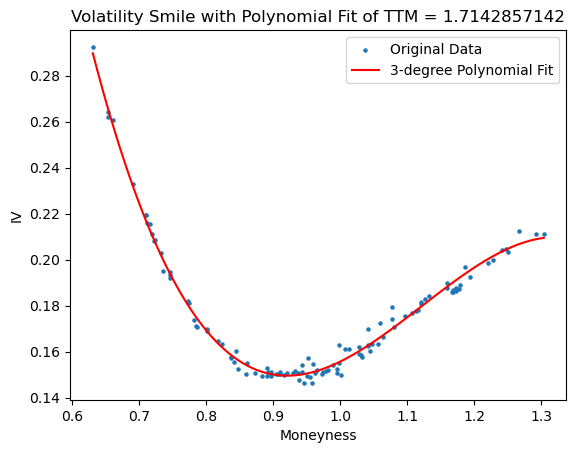

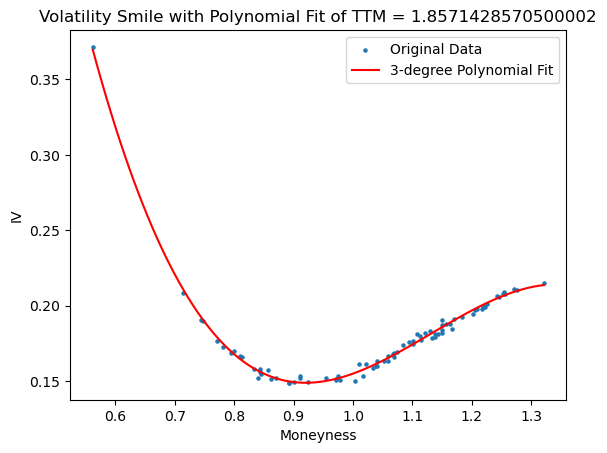

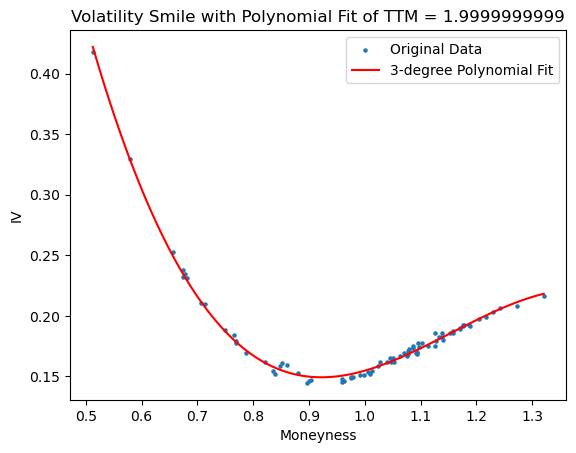

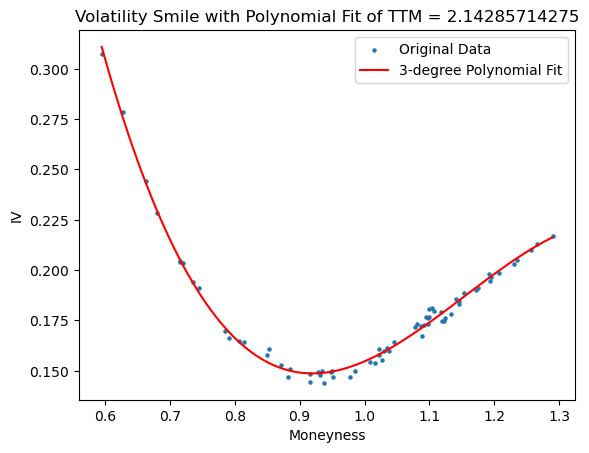

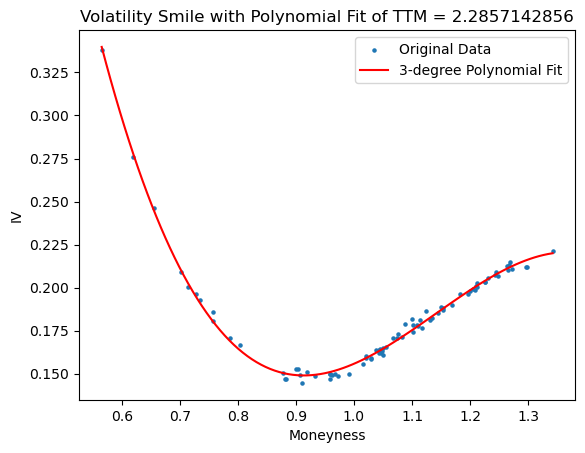

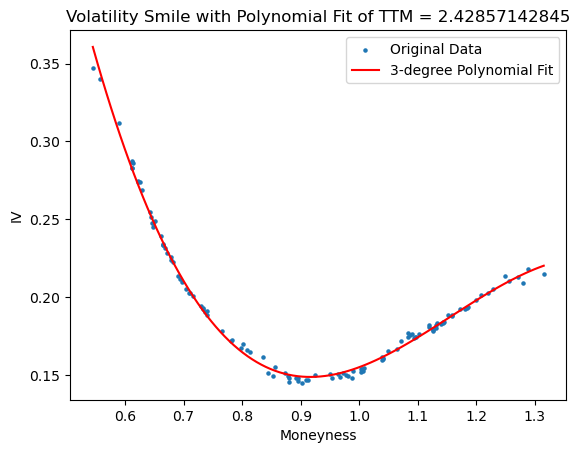

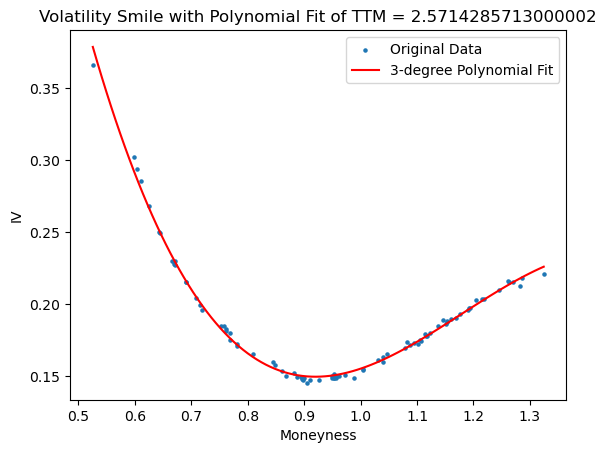

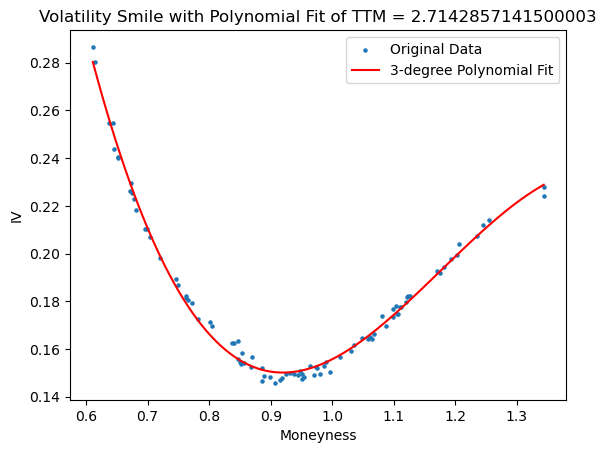

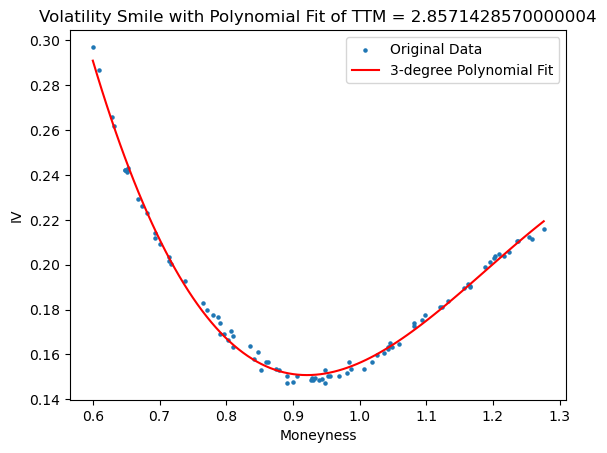

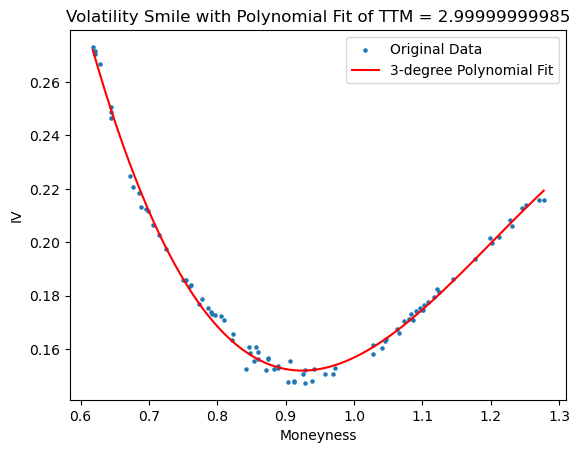

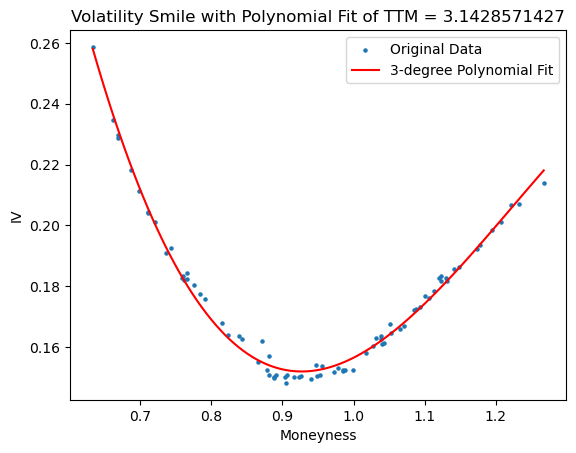

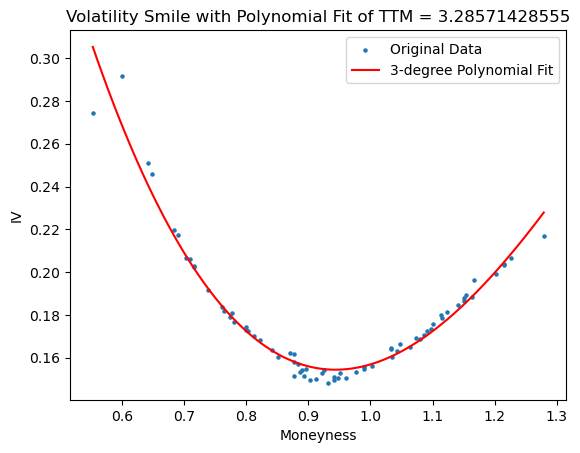

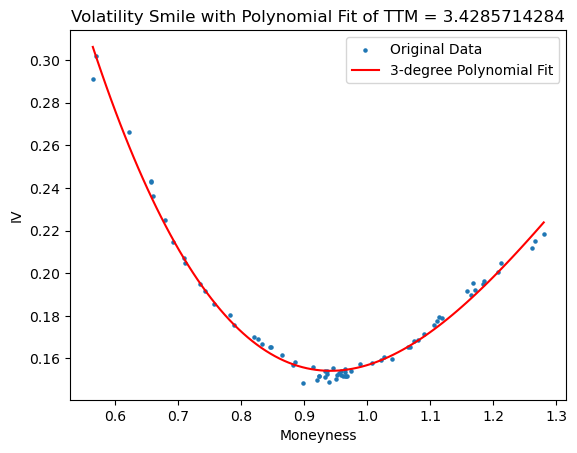

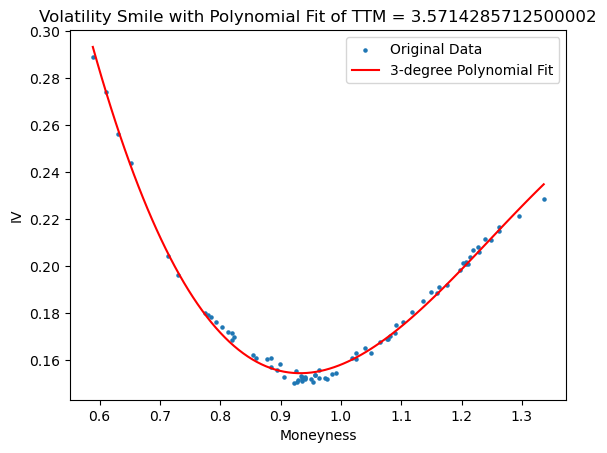

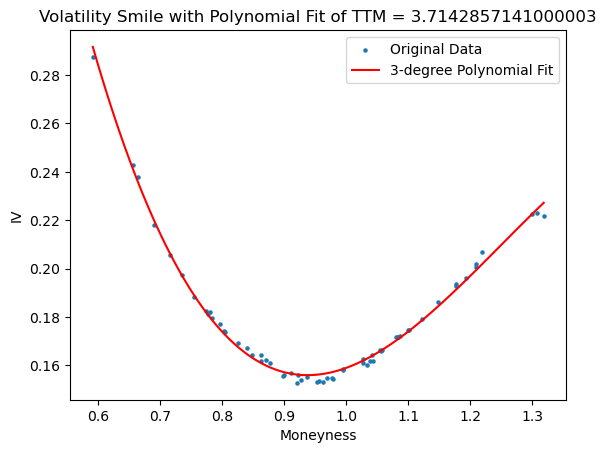

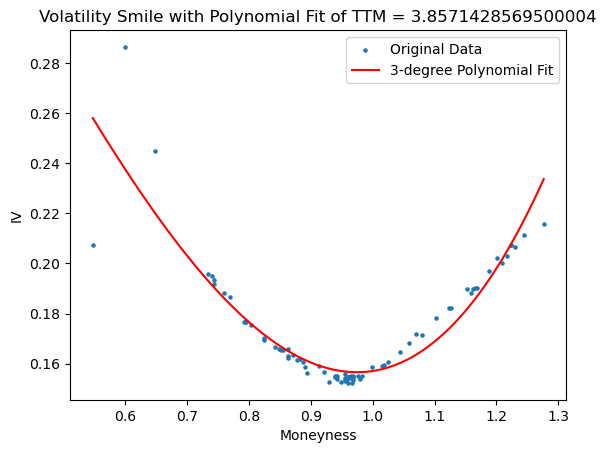

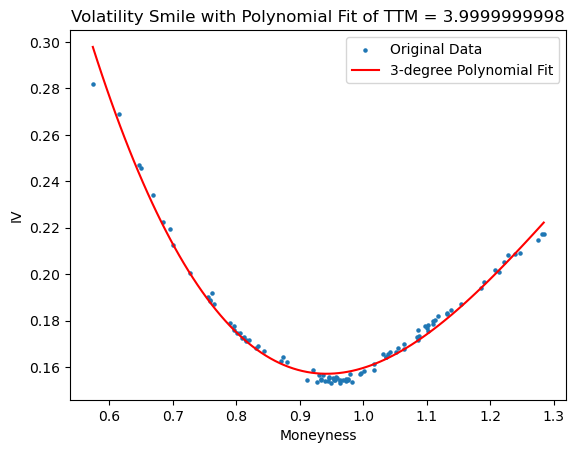

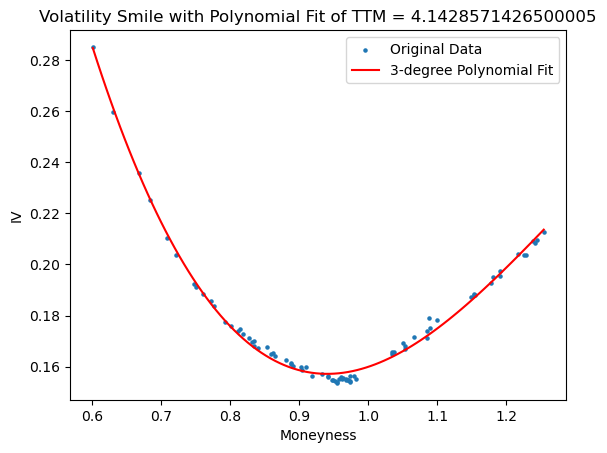

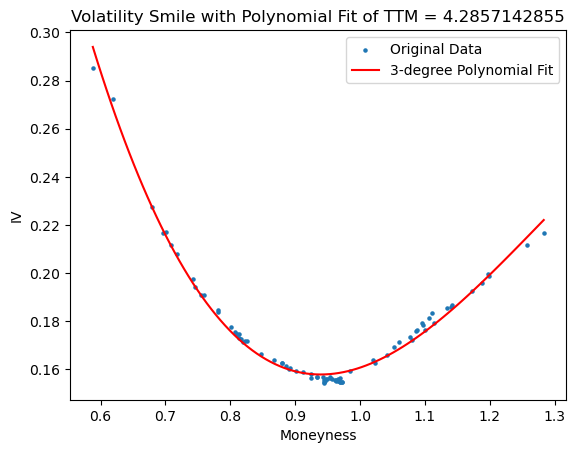

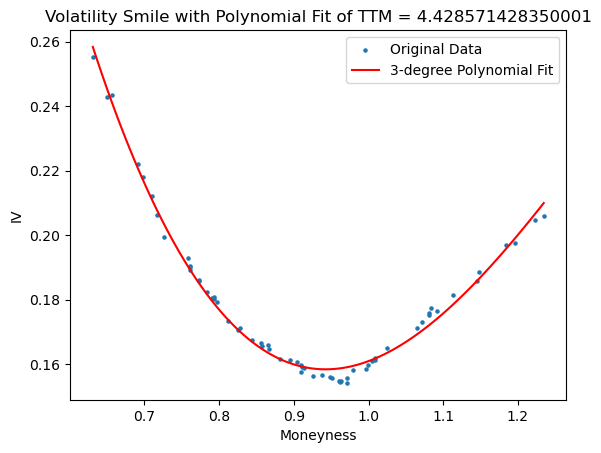

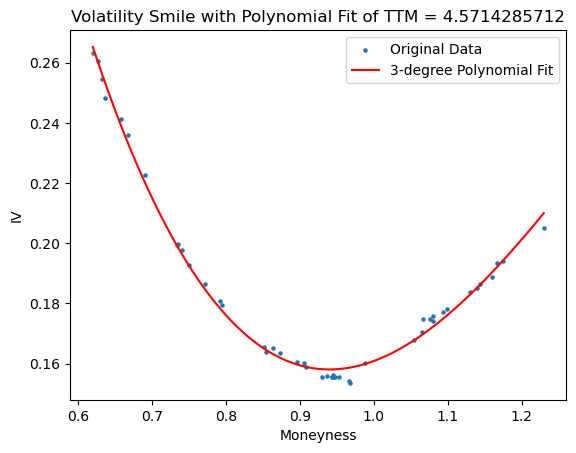

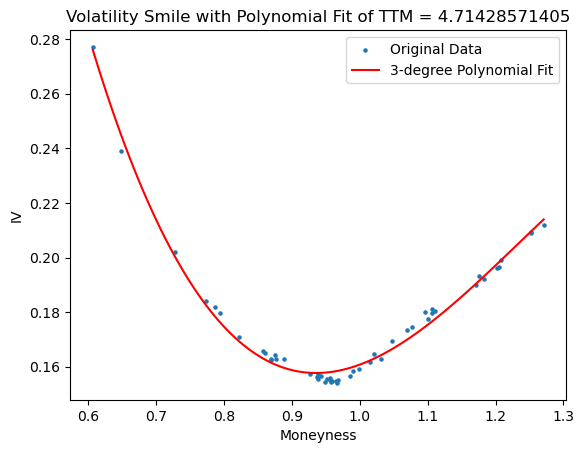

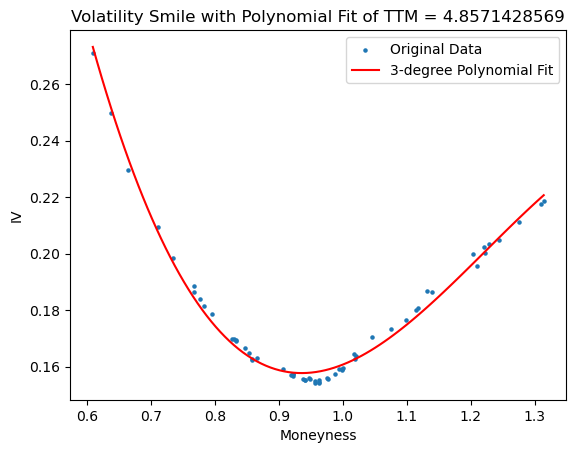

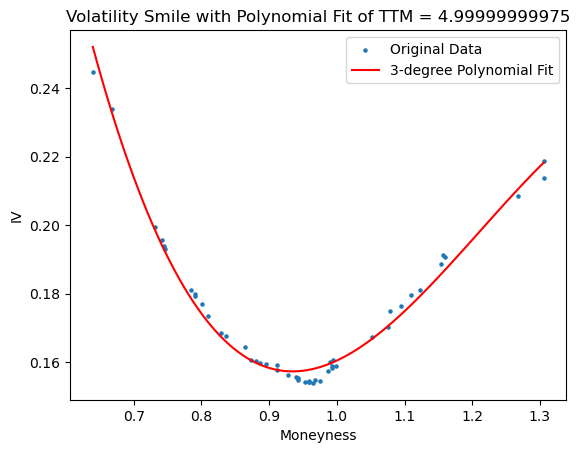

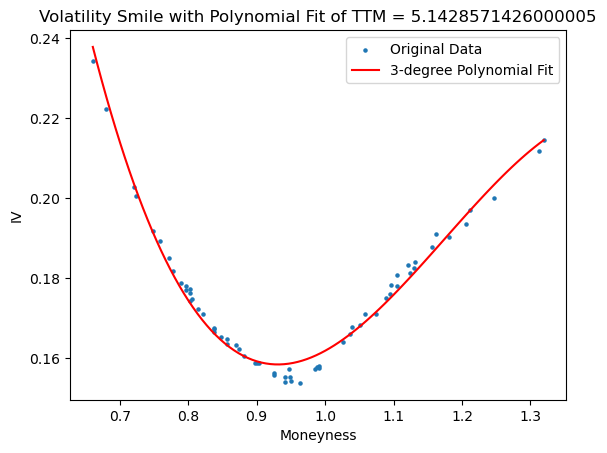

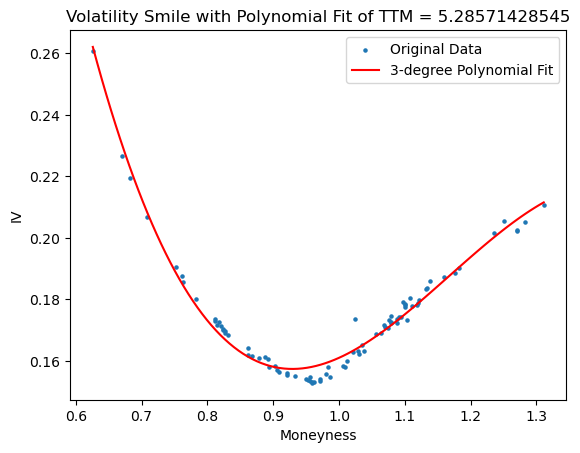

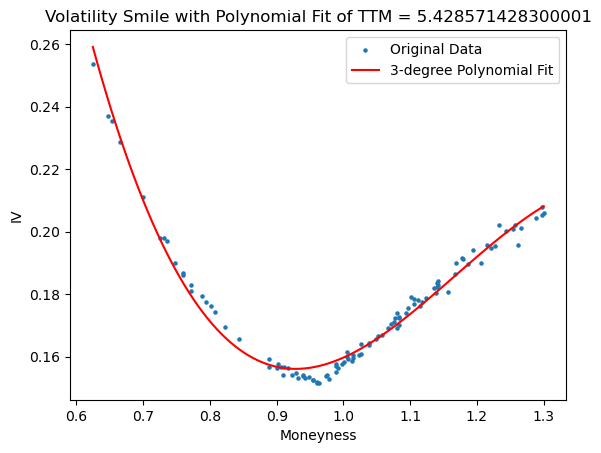

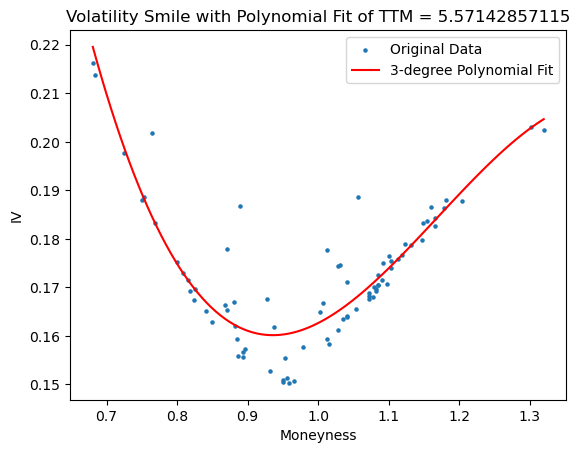

In [18]:
# Fit a polynomial of degree n (e.g., n=3 for cubic)
n = 3

for ttm in unique_ttms:
    subset = simulated_data_df[simulated_data_df['TTM'] == ttm]
    subset_sorted = subset.sort_values(by='Moneyness')  


    coefficients = np.polyfit(subset_sorted['Moneyness'], subset_sorted['iv'], n)
# Create a polynomial function with the obtained coefficients
    polynomial = np.poly1d(coefficients)

# Generate x values for plotting the polynomial curve
    x_values = np.linspace(subset_sorted['Moneyness'].min(), subset_sorted['Moneyness'].max(), 100)

# Plot the original data and the fitted polynomial curve
    plt.figure()
    plt.scatter(subset_sorted['Moneyness'], subset_sorted['iv'], label='Original Data', s = 5)
    plt.plot(x_values, polynomial(x_values), color='red', label=f'{n}-degree Polynomial Fit')
    plt.title(f'Volatility Smile with Polynomial Fit of TTM = {ttm}')
    plt.xlabel('Moneyness')
    plt.ylabel('IV')
    plt.legend()
#    save_path = os.path.join(r"C:\Users\jesper\Documents\FinTech\Research Project\plots", f'TTM_{ttm}.png')
#    plt.savefig(save_path)
    plt.show()

simulated_data_df['futures_close'] = (simulated_data_df['futures_close'] / accuracy).round() * accuracy
unique_combinations = simulated_data_df[['TTM', 'futures_close']].drop_duplicates()
kurtosis = []
skewness = []
labels = []
for index, row in unique_combinations.iterrows():
    specific_expiration_date = row['TTM']
    specific_future_close = row['futures_close']
    
    # Filter data for the specific combination
    specific_conditions = (simulated_data_df['TTM'] == specific_expiration_date) & (simulated_data_df['futures_close'] == specific_future_close)
    filtered_data = simulated_data_df[specific_conditions]
    
    sorted_data = filtered_data.sort_values(by='Moneyness')
    kurtosis_value = filtered_data['iv'].kurtosis()
    if kurtosis_value <20:
        kurtosis.append(kurtosis_value)
        labels.append(f'{specific_expiration_date} - {specific_future_close}')
        skewness.append(filtered_data['iv'].skew())
    plt.figure()
    plt.plot(sorted_data['Moneyness'], sorted_data['iv'])
    plt.title(f'Implied Volatility vs Moneyness\nExpiration Date: {specific_expiration_date}, Future Close: {specific_future_close}')
    plt.xlabel('Moneyness')
    plt.ylabel('Implied Volatility')
    plt.grid(True)

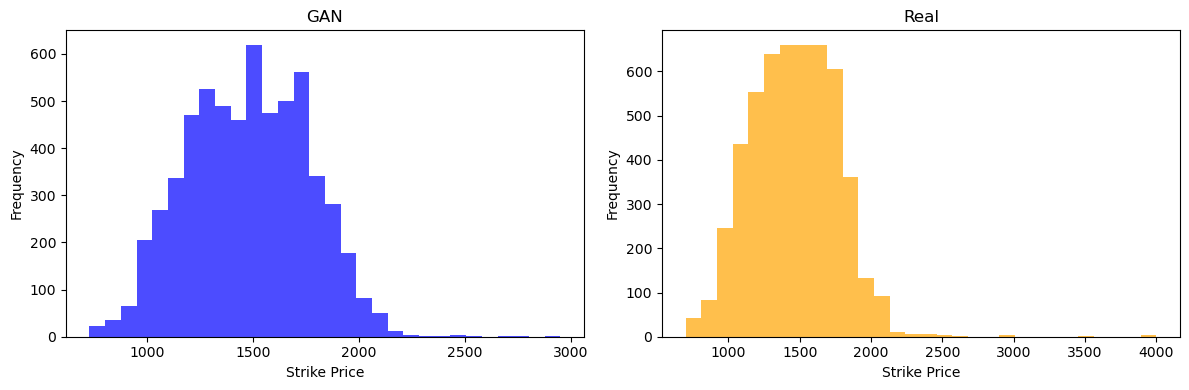

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)  # First subplot
plt.hist(simulated_data_df['strike'], bins=30, color='blue', alpha=0.7)
plt.title('GAN')
plt.xlabel('Strike Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)  # Second subplot
plt.hist(data['strike'], bins=30, color='orange', alpha=0.7)
plt.title('Real')
plt.xlabel('Strike Price')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

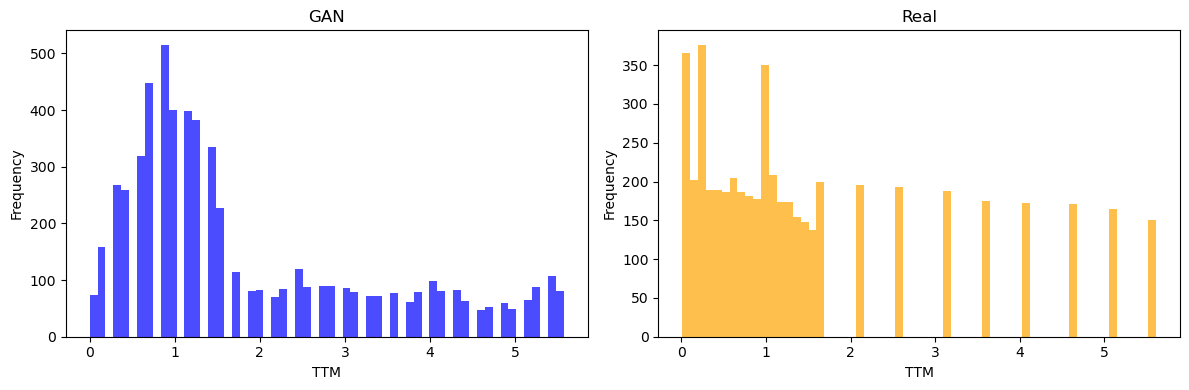

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)  # First subplot
plt.hist(simulated_data_df['TTM'], bins=60, color='blue', alpha=0.7)
plt.title('GAN')
plt.xlabel('TTM')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)  # Second subplot
plt.hist(data['TTM'], bins=60, color='orange', alpha=0.7)
plt.title('Real')
plt.xlabel('TTM')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

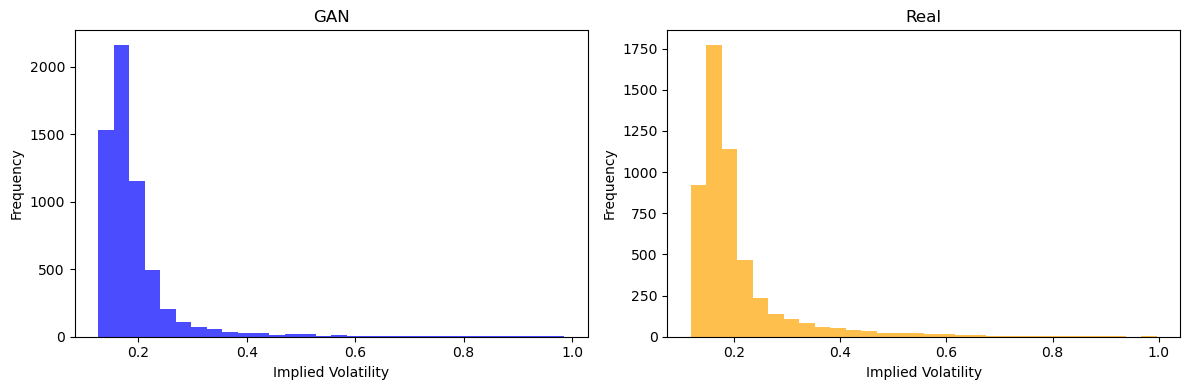

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)  # First subplot
plt.hist(simulated_data_df['iv'], bins=30, color='blue', alpha=0.7)
plt.title('GAN')
plt.xlabel('Implied Volatility')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)  # Second subplot
plt.hist(data['iv'], bins=30, color='orange', alpha=0.7)
plt.title('Real')
plt.xlabel('Implied Volatility')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

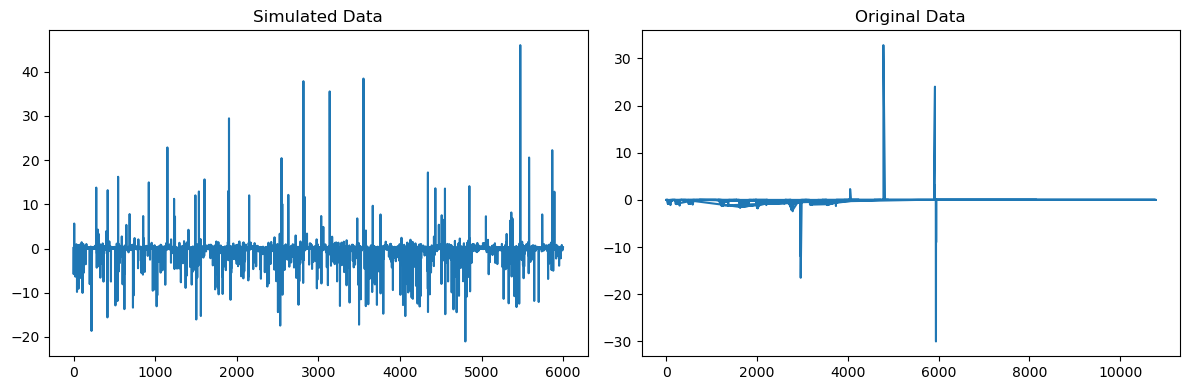

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first subplot
plt.subplot(1, 2, 1)
plt.plot(simulated_data_df['bid'] - simulated_data_df['ask'])
plt.title('Simulated Data')

# Plot the second subplot
plt.subplot(1, 2, 2)
plt.plot(data['bid'] - data['ask'])
plt.title('Original Data')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [23]:
print(len(subset_sorted['Moneyness']))
print(len(subset_sorted['iv'].groupby(subset_sorted['Moneyness']).mean()))


81
81


In [24]:
print(subset_sorted['Moneyness'].duplicated().any())
print(subset_sorted['Moneyness'].unique())

False
[0.68058065 0.68339909 0.7244019  0.74964854 0.75258366 0.76451846
 0.76840037 0.79972169 0.80909421 0.81555394 0.81850479 0.82460078
 0.82476483 0.84038864 0.84947629 0.86795514 0.87122039 0.87145104
 0.88113972 0.88147719 0.88463032 0.88700052 0.88980686 0.89370474
 0.89370713 0.8966661  0.92763125 0.93128903 0.93790251 0.95028474
 0.95038135 0.953281   0.95655031 0.95937866 0.96548363 0.97872938
 1.00294016 1.00654512 1.01208498 1.01271832 1.01543663 1.02822824
 1.02851764 1.03126016 1.03494088 1.04100577 1.04101478 1.04129672
 1.05380113 1.05630556 1.07212411 1.07226315 1.0727542  1.07836303
 1.07899302 1.08142419 1.08183232 1.08450769 1.08487076 1.08496333
 1.09126787 1.09149444 1.09763478 1.10074143 1.10335792 1.10390234
 1.1128534  1.11905546 1.12282621 1.1322628  1.14727039 1.1480367
 1.15378034 1.16048719 1.16584373 1.1660397  1.17835255 1.18190805
 1.20396428 1.30168615 1.31992136]


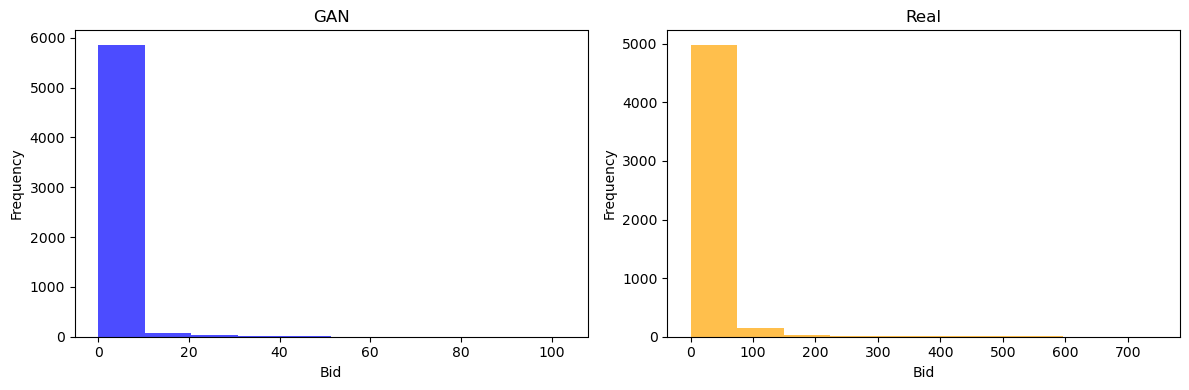

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)  # First subplot
plt.hist(simulated_data_df['bid'], bins=10, color='blue', alpha=0.7)
plt.title('GAN')
plt.xlabel('Bid')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)  # Second subplot
plt.hist(data['bid'], bins=10, color='orange', alpha=0.7)
plt.title('Real')
plt.xlabel('Bid')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

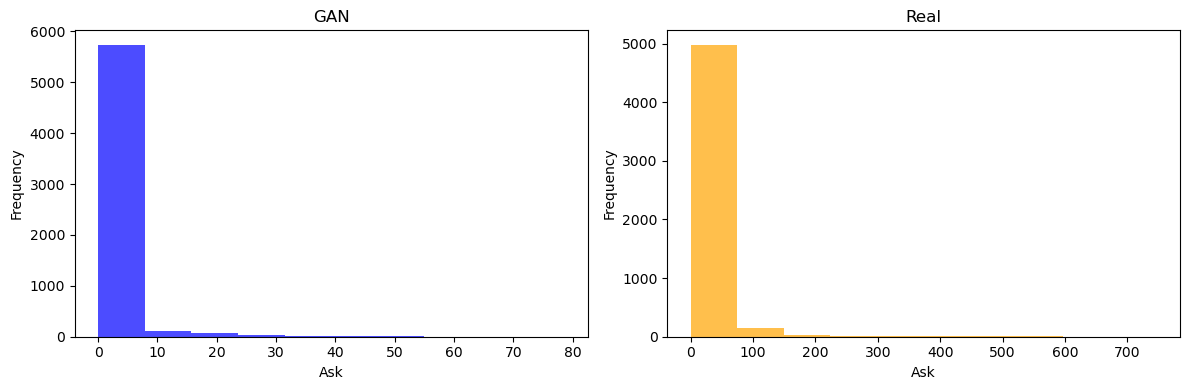

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)  # First subplot
plt.hist(simulated_data_df['ask'], bins=10, color='blue', alpha=0.7)
plt.title('GAN')
plt.xlabel('Ask')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)  # Second subplot
plt.hist(data['ask'], bins=10, color='orange', alpha=0.7)
plt.title('Real')
plt.xlabel('Ask')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()